In [844]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from scipy.optimize import root
from math import sqrt, exp, sin
from matplotlib.backends.backend_pdf import PdfPages

Определим функции, которые будут возвращать производные v(t) и u(t) по времени dv_dt(t, y) и du_dt(t, y), соответсвенно, и функцию if_pulse(y) для того, чтобы задать ограничение на решение системы ОДУ. Хоть время и явно не указанно в системе, при написании численных методов, будем исходить из соображений универсальности, а не опираться на конкретную задачу, поэтому в функции также передаем и параметр t, отвечающий за время.

In [582]:
def function(dsm):
    
    def dv_dt(t, y):
        return 0.04 * y[0] ** 2 + 5 * y[0] + 140 - y[1] + 5

    def du_dt(t, y):
        return dsm[0] * (dsm[1] * y[0] - y[1])
    
    def if_pulse(y):
        if y[0] >= 30:
            return [dsm[2], y[1] + dsm[3]]
        else:
            return y
        
    return [dv_dt, du_dt, if_pulse]

Для дальнейшего удобства создадим словарь с режимами заданной динамической системы в качестве ключей и списками параметров для каждого режима в качестве значений. Для вывода названий режимов на графиках, зададим список со строками названий этих режимов.

In [701]:
DSM = {'TS' : [0.02, 0.2, -65, 6],
       'PS' : [0.02, 0.25, -65, 6],
       'C' : [0.02, 0.2, -50, 2],
       'FS' : [0.1, 0.2, -65, 2]}
DSM_names = ['Tonic spiking', 'Phasic spiking', 'Chattering', 'Fast spiking']

Создадим список функций для передачи его в методы численного интегрирования системы ОДУ.

In [584]:
f = [function(DSM['TS']), function(DSM['PS']), function(DSM['C']), function(DSM['FS'])]

Зададим значения шага h и времени, в течении которого будет происходить моделирование.

In [670]:
h, t = 0.5, 300

Определим функцию задания начальных условий.

In [558]:
def init_cond(dsm):
    return [dsm[2], dsm[1] * dsm[2]]

Явный метод Эйлера.

In [934]:
def euler(x_0, t_n, f, h):
    n = len(f) - 1
    w = [x_0]
    
    for t in np.arange(h, t_n + h, h):
        w.append([])
        for j in range(n):
            w[-1].append(w[-2][j] + h * f[j](t, w[-2]))
        
        w[-1] = f[-1](w[-1])
        
    return w

Неявный метод Эйлера.

In [939]:
def implicit_euler(x_0, t_n, f, h):
    n = len(f) - 1
    w = [x_0]

    def sys_eq(eq):
        x = eq
        w_ = [x[i] - w[-1][i] - h * f[0](t, x) for i in range(n)]
        return w_
    
    for t in np.arange(h, t_n + h, h):
        x_0 = root(sys_eq, w[-1], method = 'df-sane').x
        w.append([])  
        for i in range(n):      
            w[-1].append(w[-2][i] + h * f[i](t, x_0))
            
        w[-1] = f[-1](w[-1])
         
    return w

Метод Рунге-Кутты.

In [942]:
def runge_kutta(x_0, t_n, f, h):
    n = len(f) - 1
    w = [x_0]
    
    for t in np.arange(h, t_n + h, h):
        k1 = np.array([h * f[i](t, w[-1]) for i in range(n)])
        k2 = np.array([h * f[i](t + h / 2, [x + y / 2 for x, y in zip(w[-1], k1)])
                       for i in range(n)])
        k3 = np.array([h * f[i](t + h / 2, [x + y / 2 for x, y in zip(w[-1], k2)]) 
                       for i in range(n)])
        k4 = np.array([h * f[i](t + h, [x + y for x, y in zip(w[-1], k3)]) 
                       for i in range(n)])
        w.append(list([x + (p + 2*y + 2*z + q) / 6 
                  for x, p, y, z, q in zip(w[-1], k1, k2, k3, k4)]))
        
        w[-1] = f[-1](w[-1])
    
    return w

Генерируем список с начальными условиями для всех указанных режимов.

In [562]:
init = [init_cond(DSM['TS']), init_cond(DSM['PS']), init_cond(DSM['C']), init_cond(DSM['FS'])]

А также списки с дискретными траекториями для всех трех методов, каждый из которых будет находить решения для четырех указанных режимов. Получим списки длиной 4, каждый элемент которых -- список со списками решений системы ОДУ (для каждого времени -- одно решение).

In [943]:
euler_ = [euler(init[i], t, f[i], h) for i in range(4)]
imp_euler_ = [implicit_euler(init[i], t, f[i], h) for i in range(4)]
kutta_ = [runge_kutta(init[i], t, f[i], h) for i in range(4)]

Список со временем.

In [937]:
time = [k for k in np.arange(0, t + h, h)]

Функции вывода графиков.

Данная функция выводит 4 графика для какого-либо метода для всех режимов работы системы. На графиках отображаются только v(t).

In [927]:
def graphic_one(x, y, n, k, a):
    fig = plt.figure(figsize=(40, 40))
    for i in range(4):
        y[i] = np.array(y[i])
        y_ = y[i].transpose()
        plt.subplot(2, 2, i + 1)
        plt.xlabel('t', fontsize=70, color='green')
        plt.ylabel(f'{a}(t)', fontsize=70, color='green')
        plt.rcParams.update({'font.size': 70}) 
        plt.plot(x, y_[k], color='green', linewidth = 0, marker = 'o', markersize = 10, markerfacecolor = 'lawngreen',
            markeredgecolor = 'limegreen', markeredgewidth = 1, label = DSM_names[i])
        plt.legend()
        plt.grid(True)
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['font.family'] = 'Calibri'
        with PdfPages(f'{n}.pdf') as pdf:
            pdf.savefig()

Данная функция на одном графике выводит все три дискретные траектории для трех методов для какого-то одного режима. На графике отбражается только v(t).

In [854]:
def graphic(x, y, n):
    fig = plt.figure(figsize=(30, 30))
    y_ = []
    for i in range(3):
        y[i] = np.array(y[i])
        y_.append(y[i].transpose())
    
    plt.xlabel('t', fontsize=60, color='green')
    plt.ylabel('v(t)', fontsize=60, color='green')
    plt.rcParams.update({'font.size': 60})
    plt.plot(x, y_[0][0], color='green', linewidth = 0, marker = 'o', markersize = 20, markerfacecolor = 'lawngreen',
            markeredgecolor = 'limegreen', markeredgewidth = 1, label = f'{DSM_names[n]}: Euler')
    plt.plot(x, y_[1][0], color='green', linewidth = 0, marker = 'o', markersize = 20, markerfacecolor = 'maroon',
            markeredgecolor = 'indianred', markeredgewidth = 1, label = f'{DSM_names[n]}: Implicit Euler')
    plt.plot(x, y_[2][0], color='green', linewidth = 0, marker = 'o', markersize = 20, markerfacecolor = 'plum',
            markeredgecolor = 'indigo', markeredgewidth = 1, label = f'{DSM_names[n]}: Runge-Kutta')
    plt.legend()
    plt.grid(True)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Calibri'
    with PdfPages(f'{n}.pdf') as pdf:
        pdf.savefig()

Данная функция выводит как график v(t), так и график u(t) для какого-то одного метода и одного режима работы. То есть два графика всего.

In [911]:
def graphic_one_u(x, y, n, k, a):
    fig = plt.figure(figsize=(30, 30))
    y = np.array(y)
    y_ = y.transpose()
    for i in range(2):
        plt.subplot(2, 1, i + 1)
        plt.xlabel('t', fontsize=60, color='green')
        plt.ylabel(f'{a[i]}(t)', fontsize=60, color='green')
        plt.rcParams.update({'font.size': 60}) 
        plt.plot(x, y_[i], color='green', linewidth = 0, marker = 'o', markersize = 10, markerfacecolor = 'y',
            markeredgecolor = 'olive', markeredgewidth = 1, label = DSM_names[k])
        plt.legend()
        plt.grid(True)
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['font.family'] = 'Calibri'
        with PdfPages(f'{n}.pdf') as pdf:
            pdf.savefig()

Выводим 4 графика, на каждом из которых для трех методов отображены сразу три траектории. Легенда указывает на название метода и название режима работы системы.

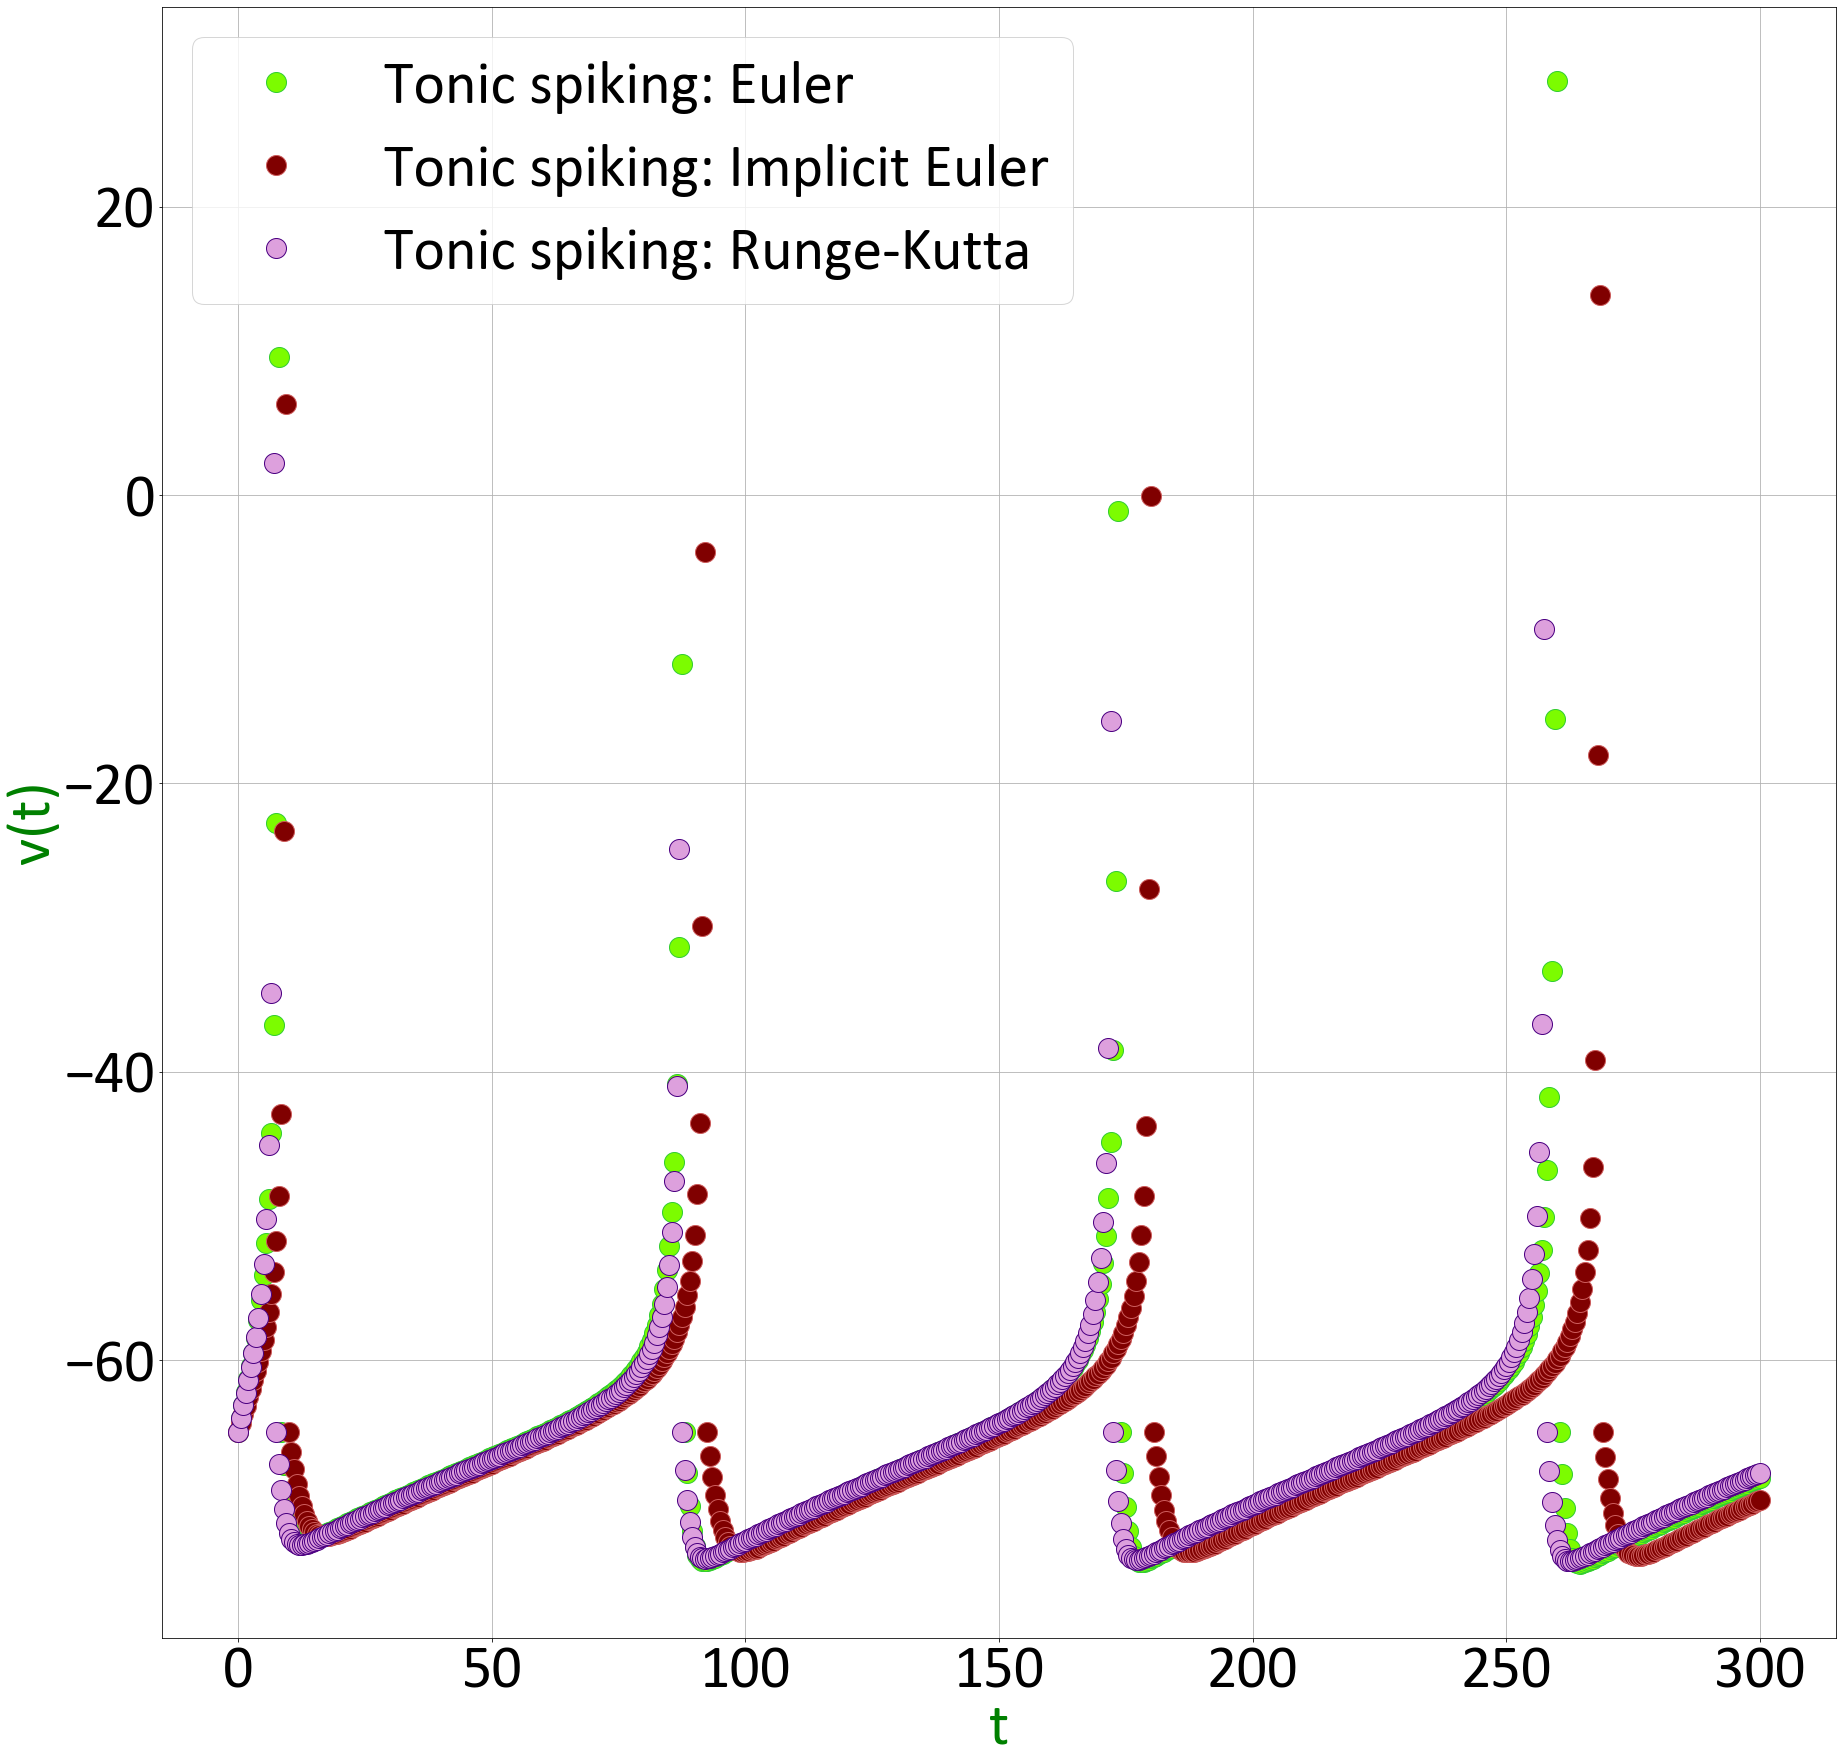

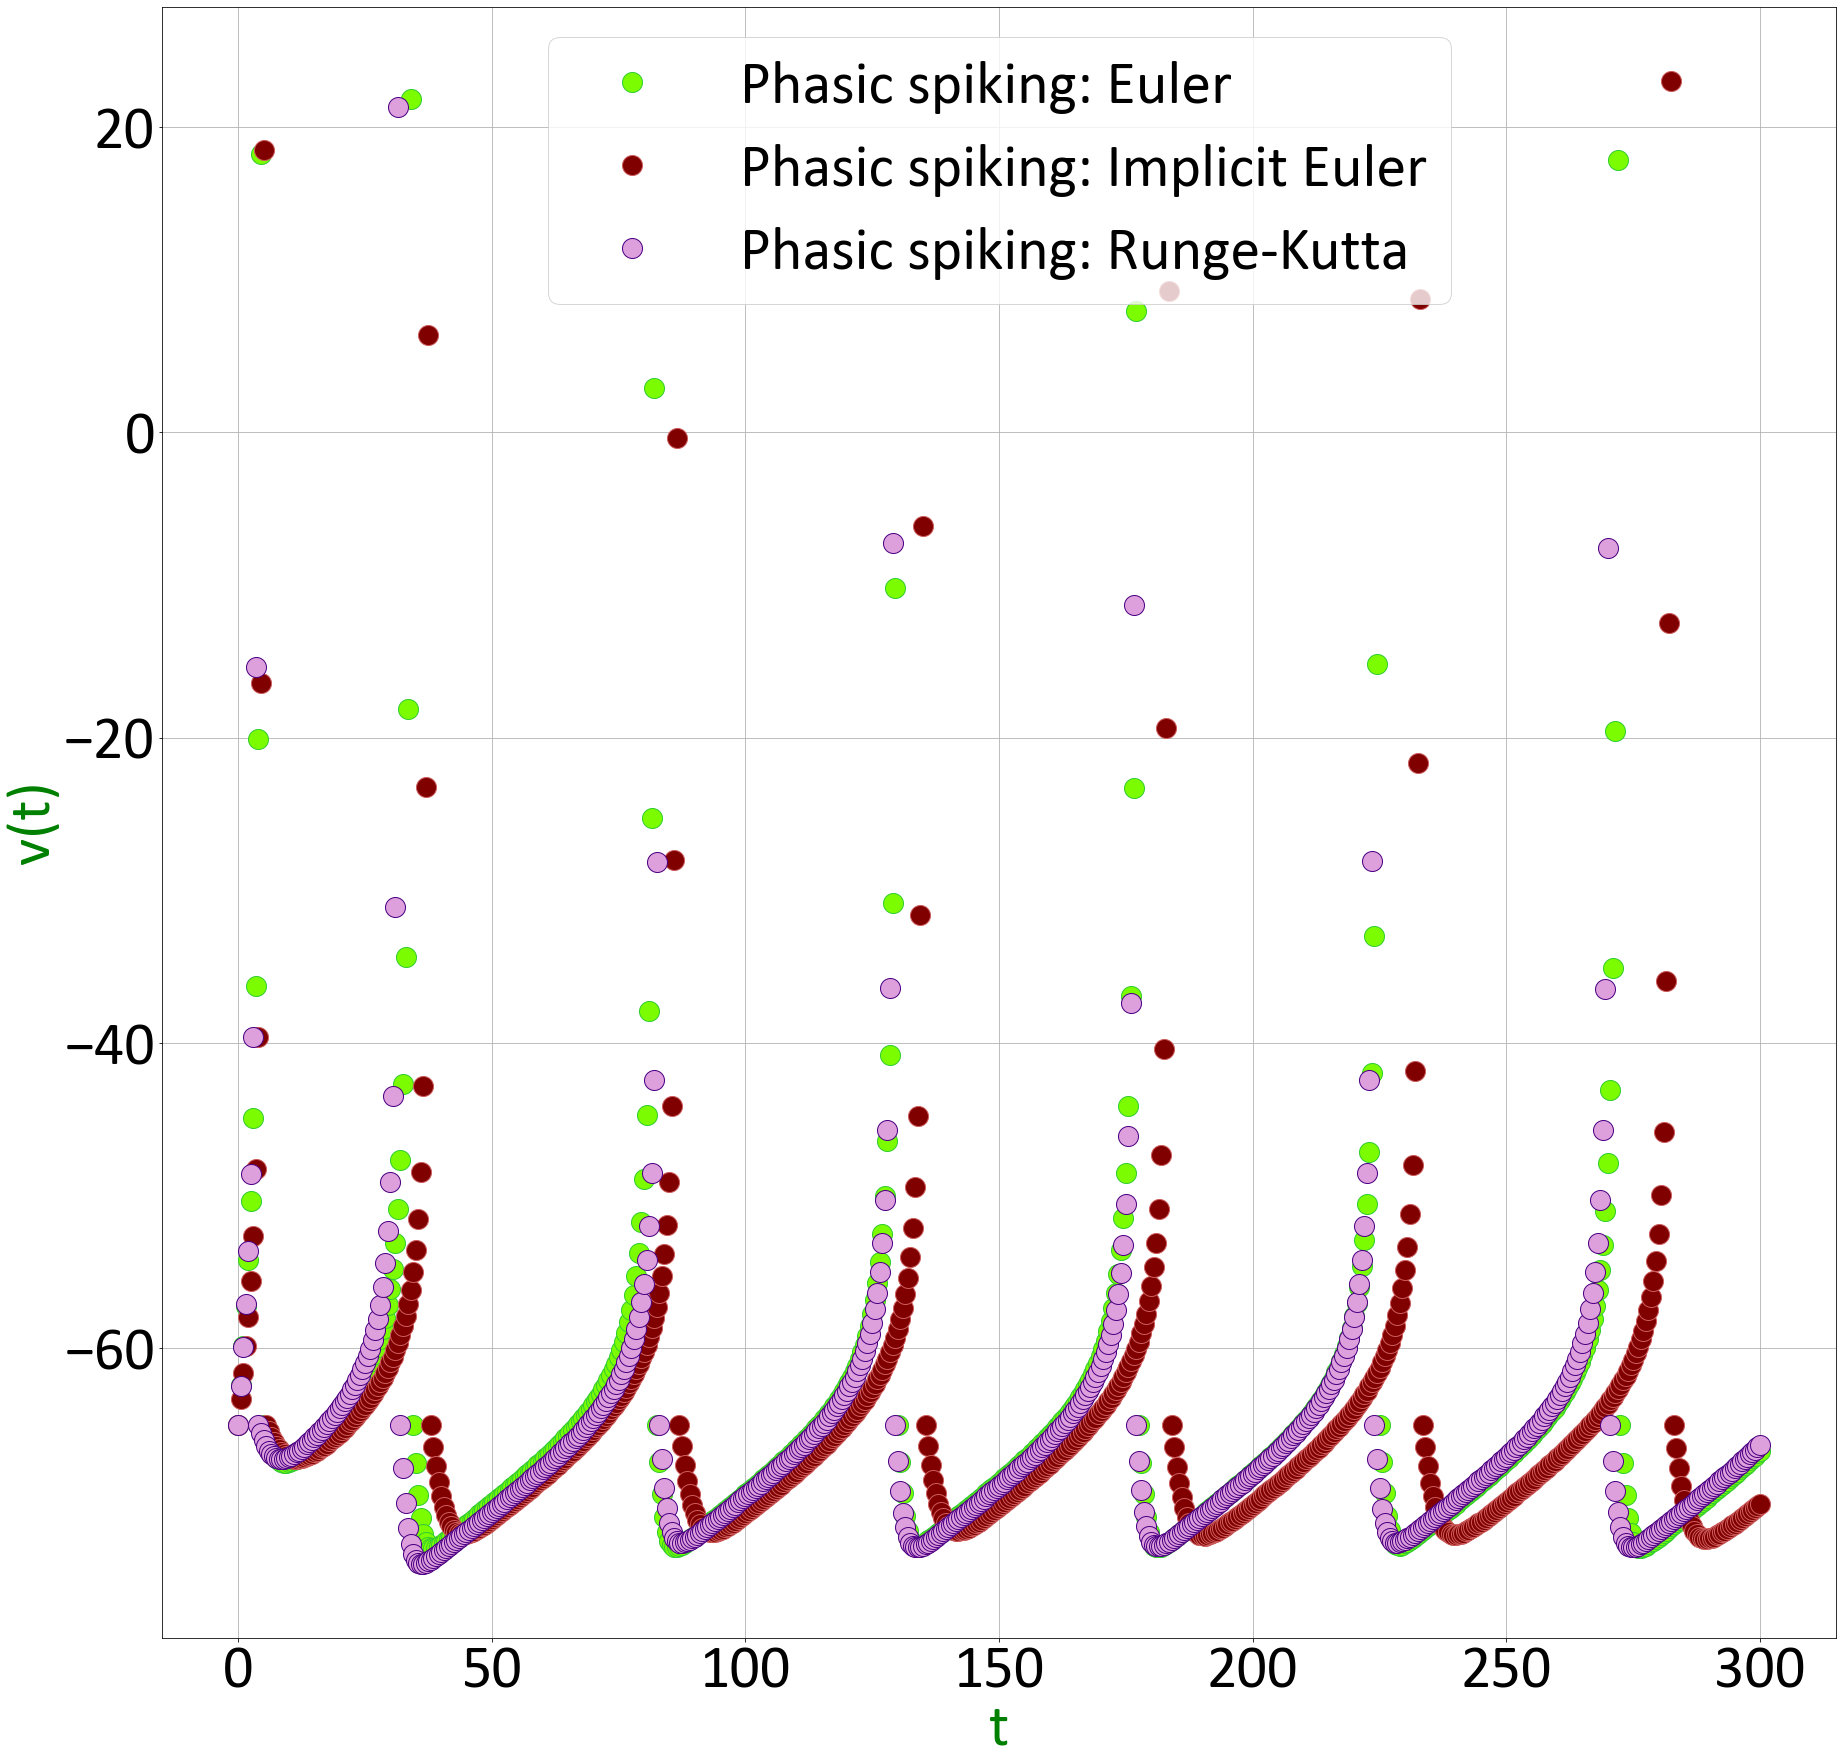

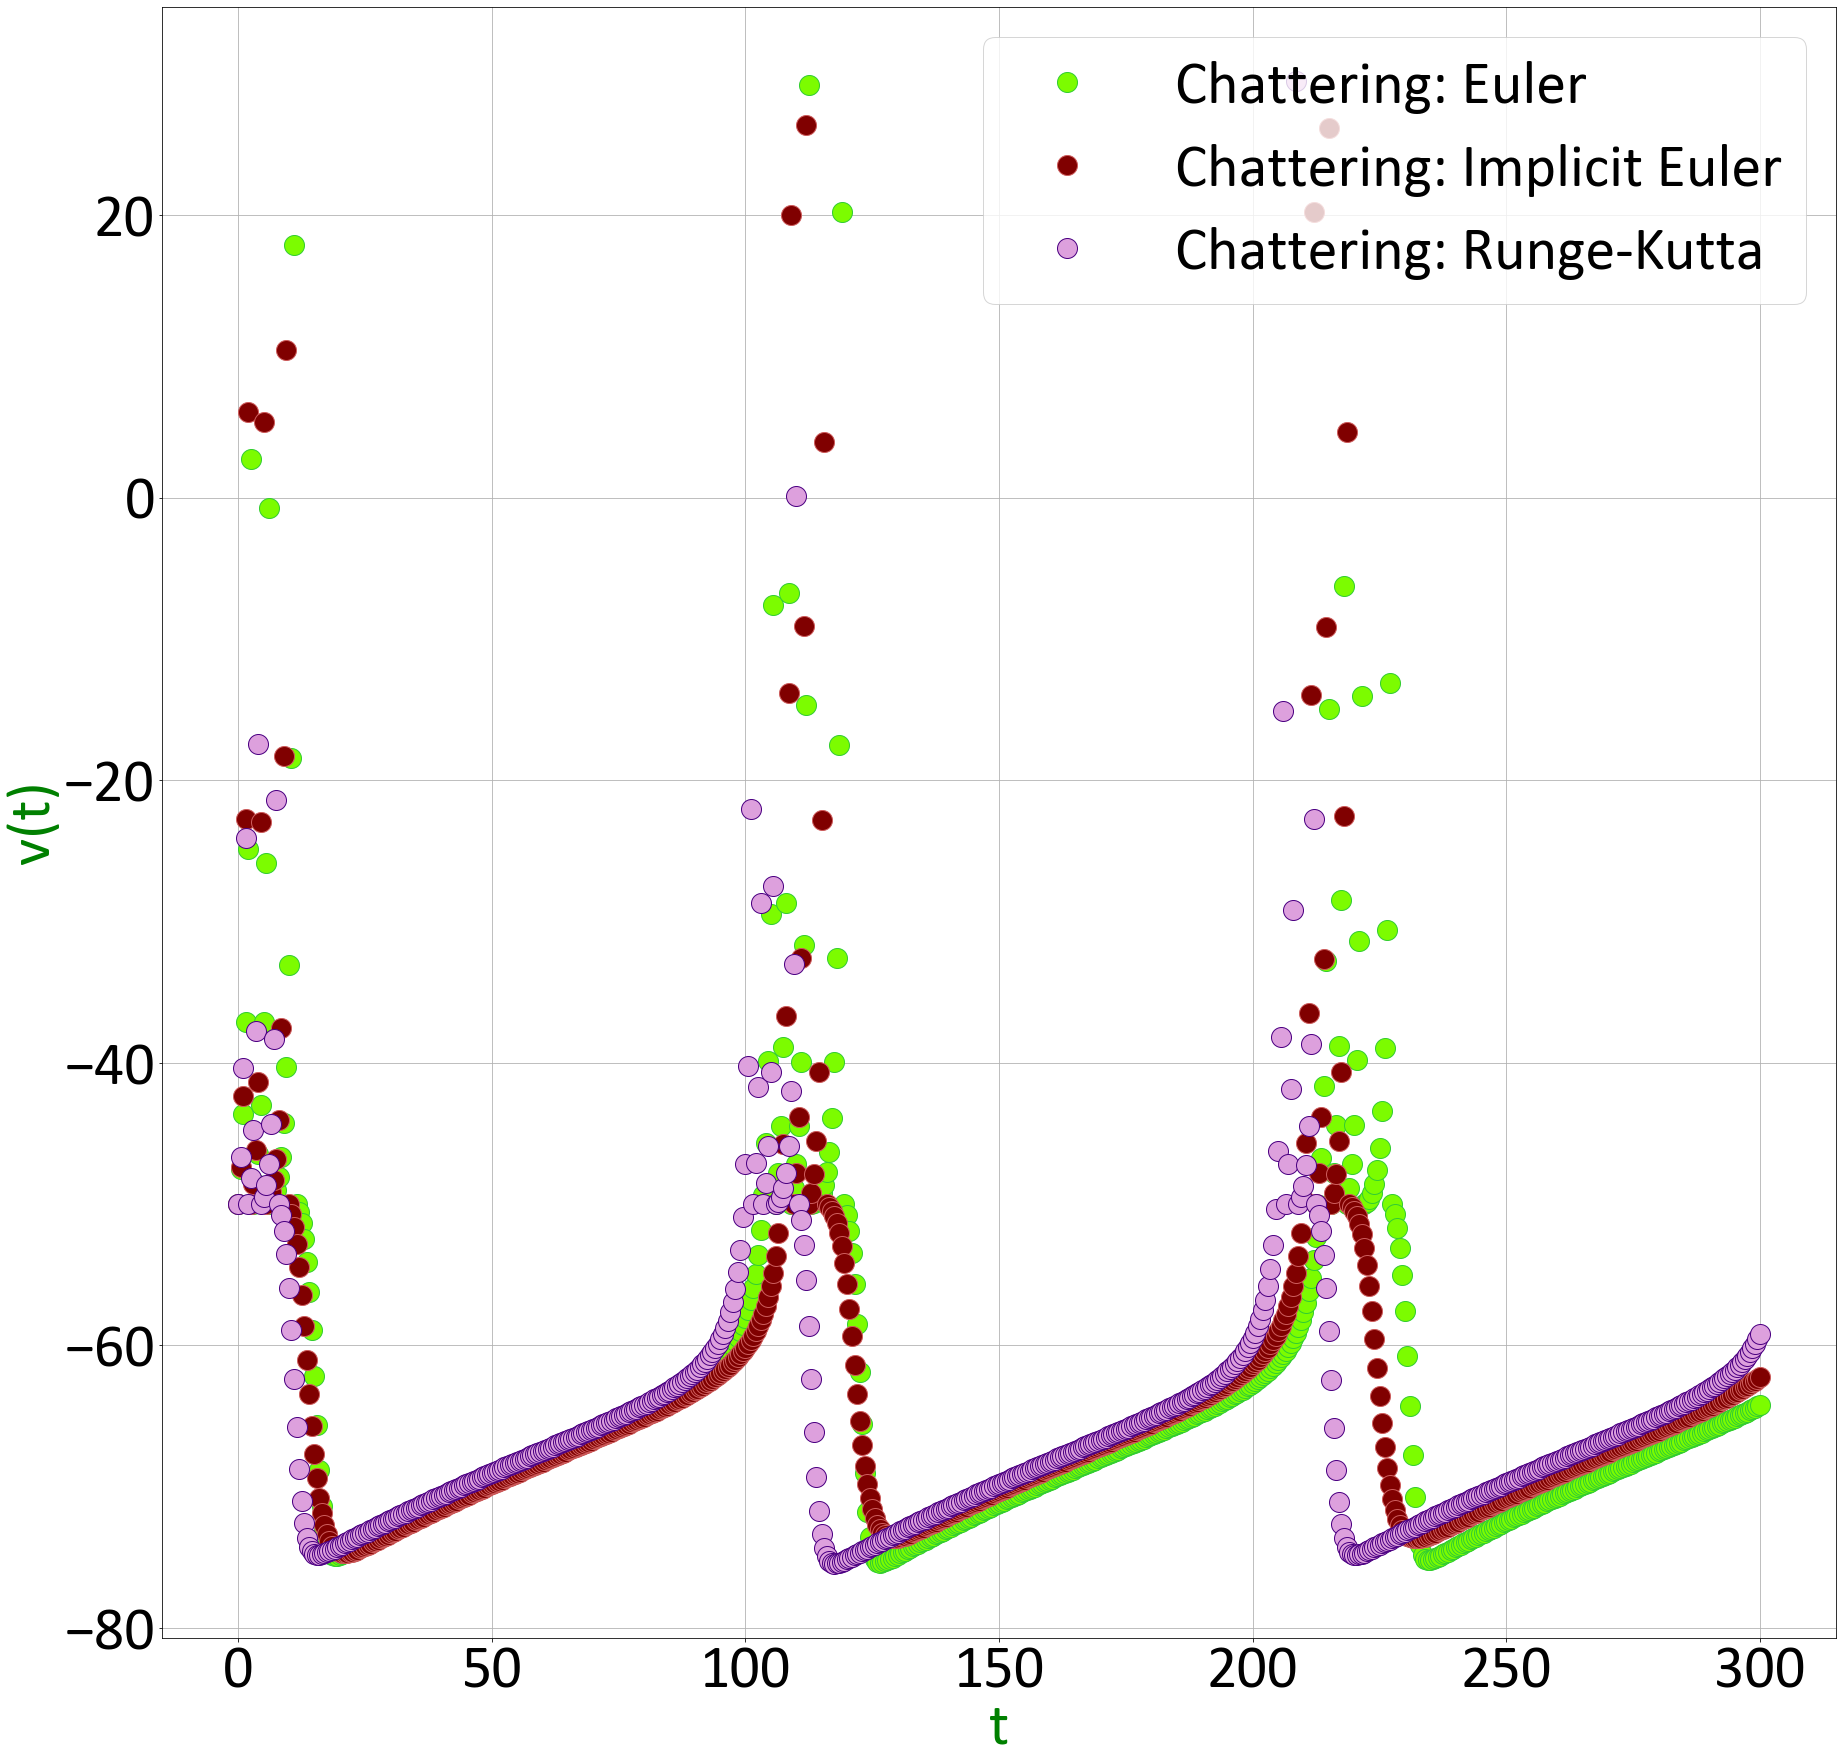

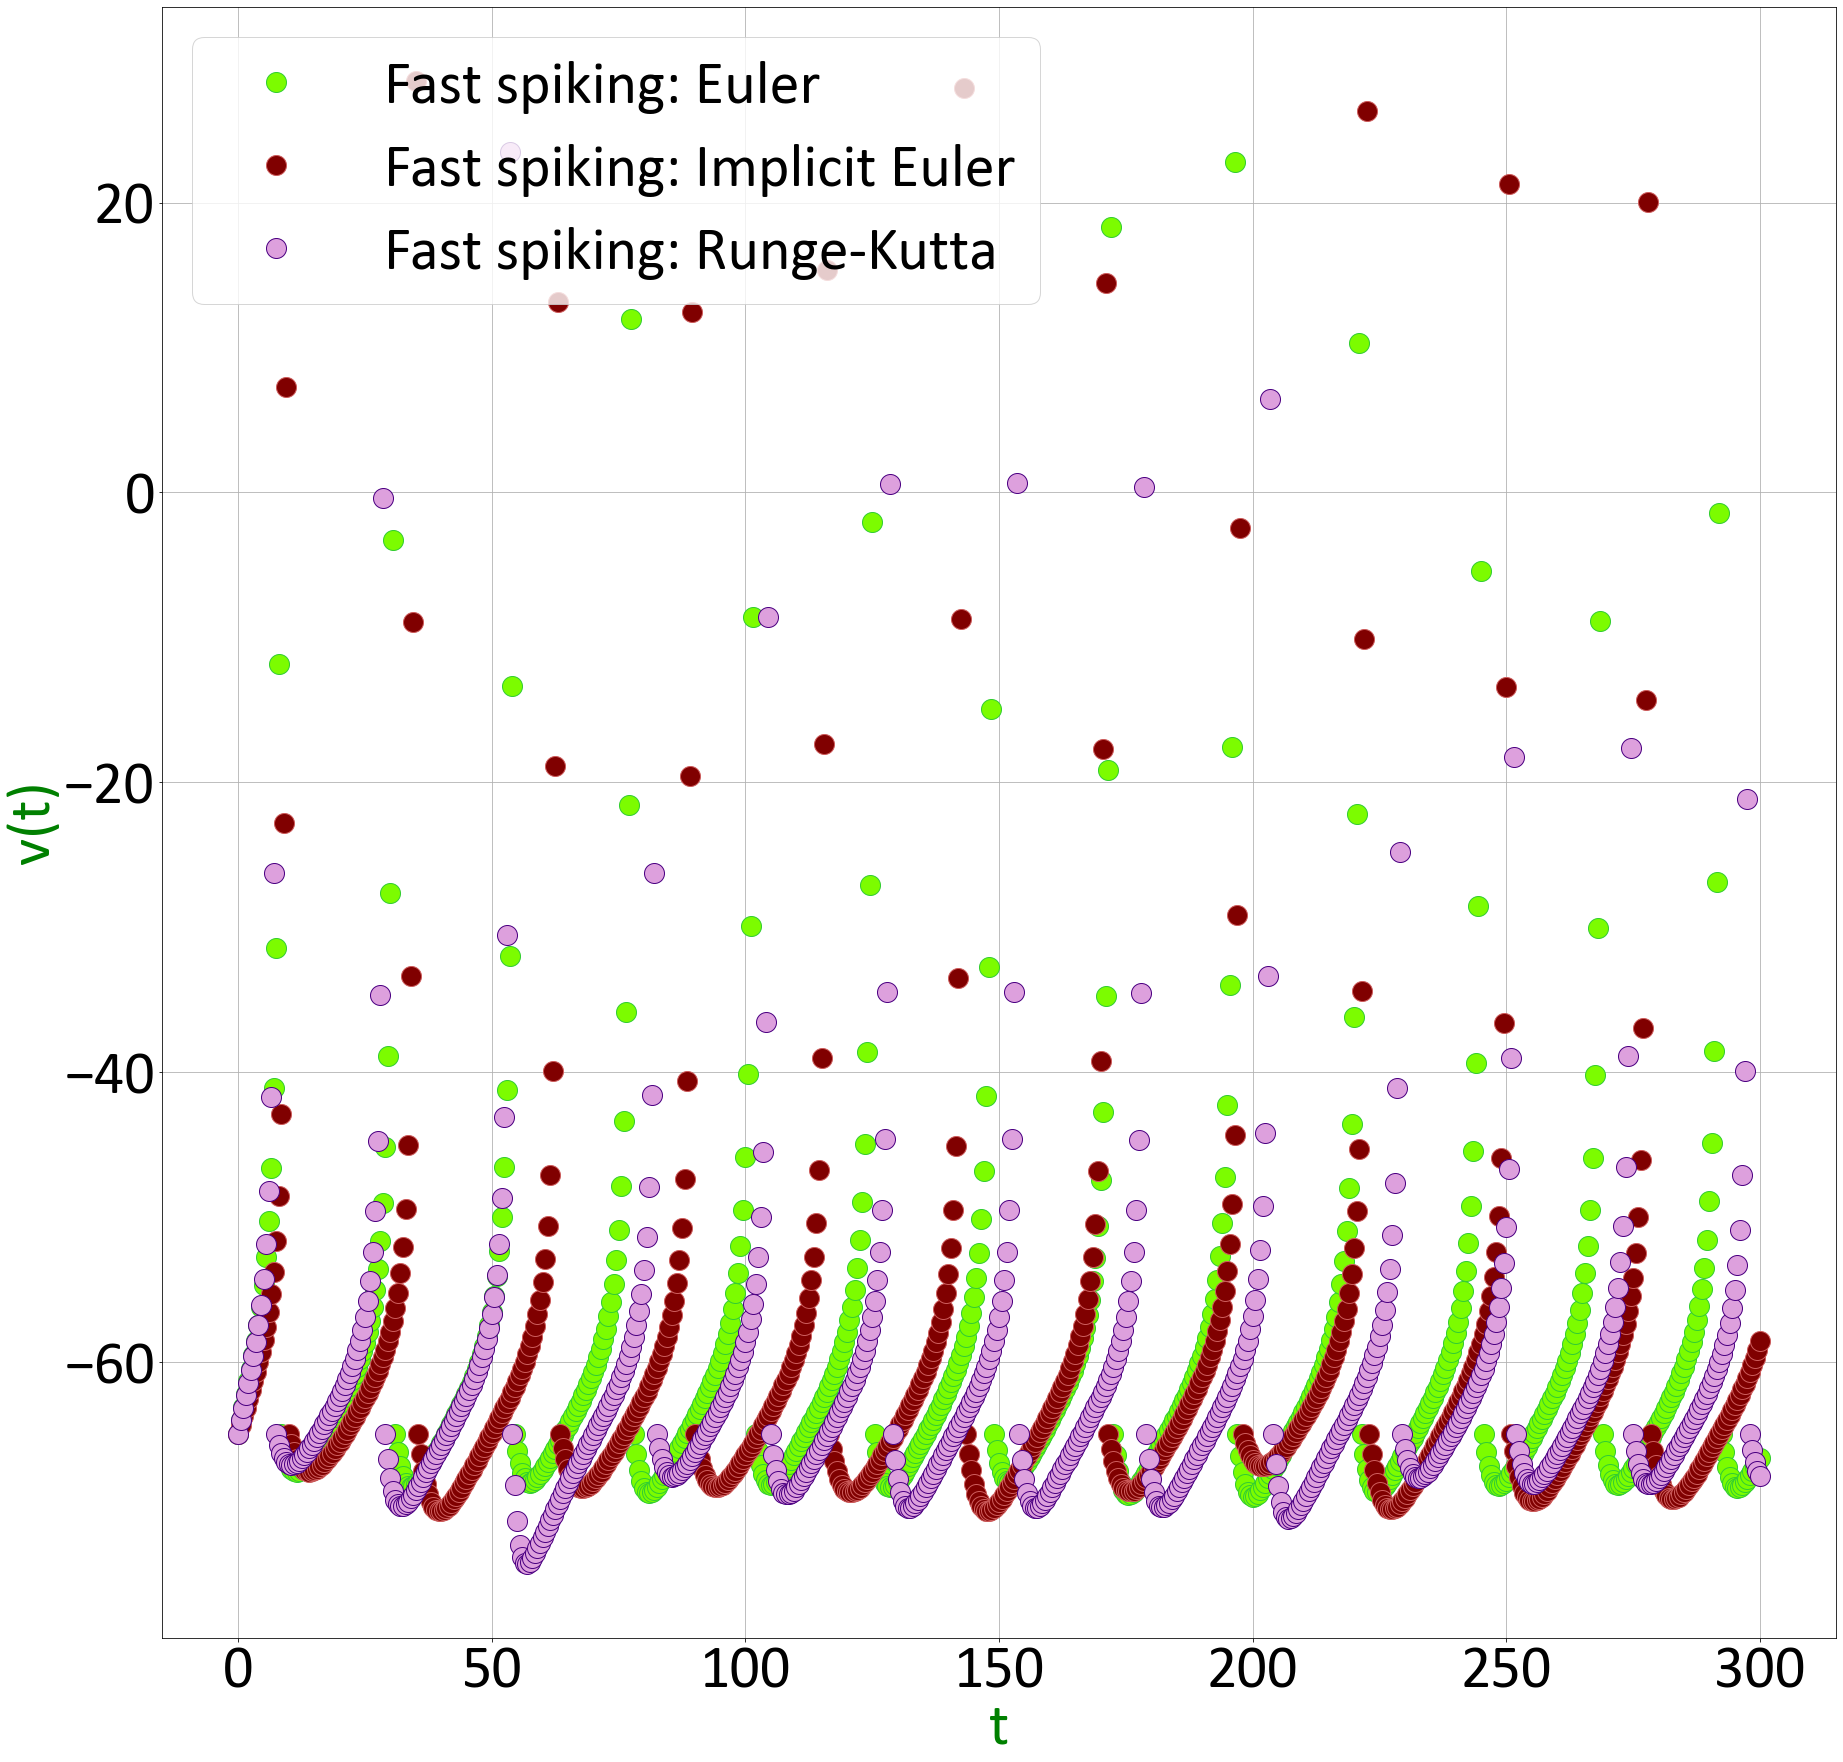

In [944]:
for i in range(4):
    graphic(time, [euler_[i], imp_euler_[i], kutta_[i]], i)

Для явного метода Эйлера выводим все 4 графика 4 режимов работы.

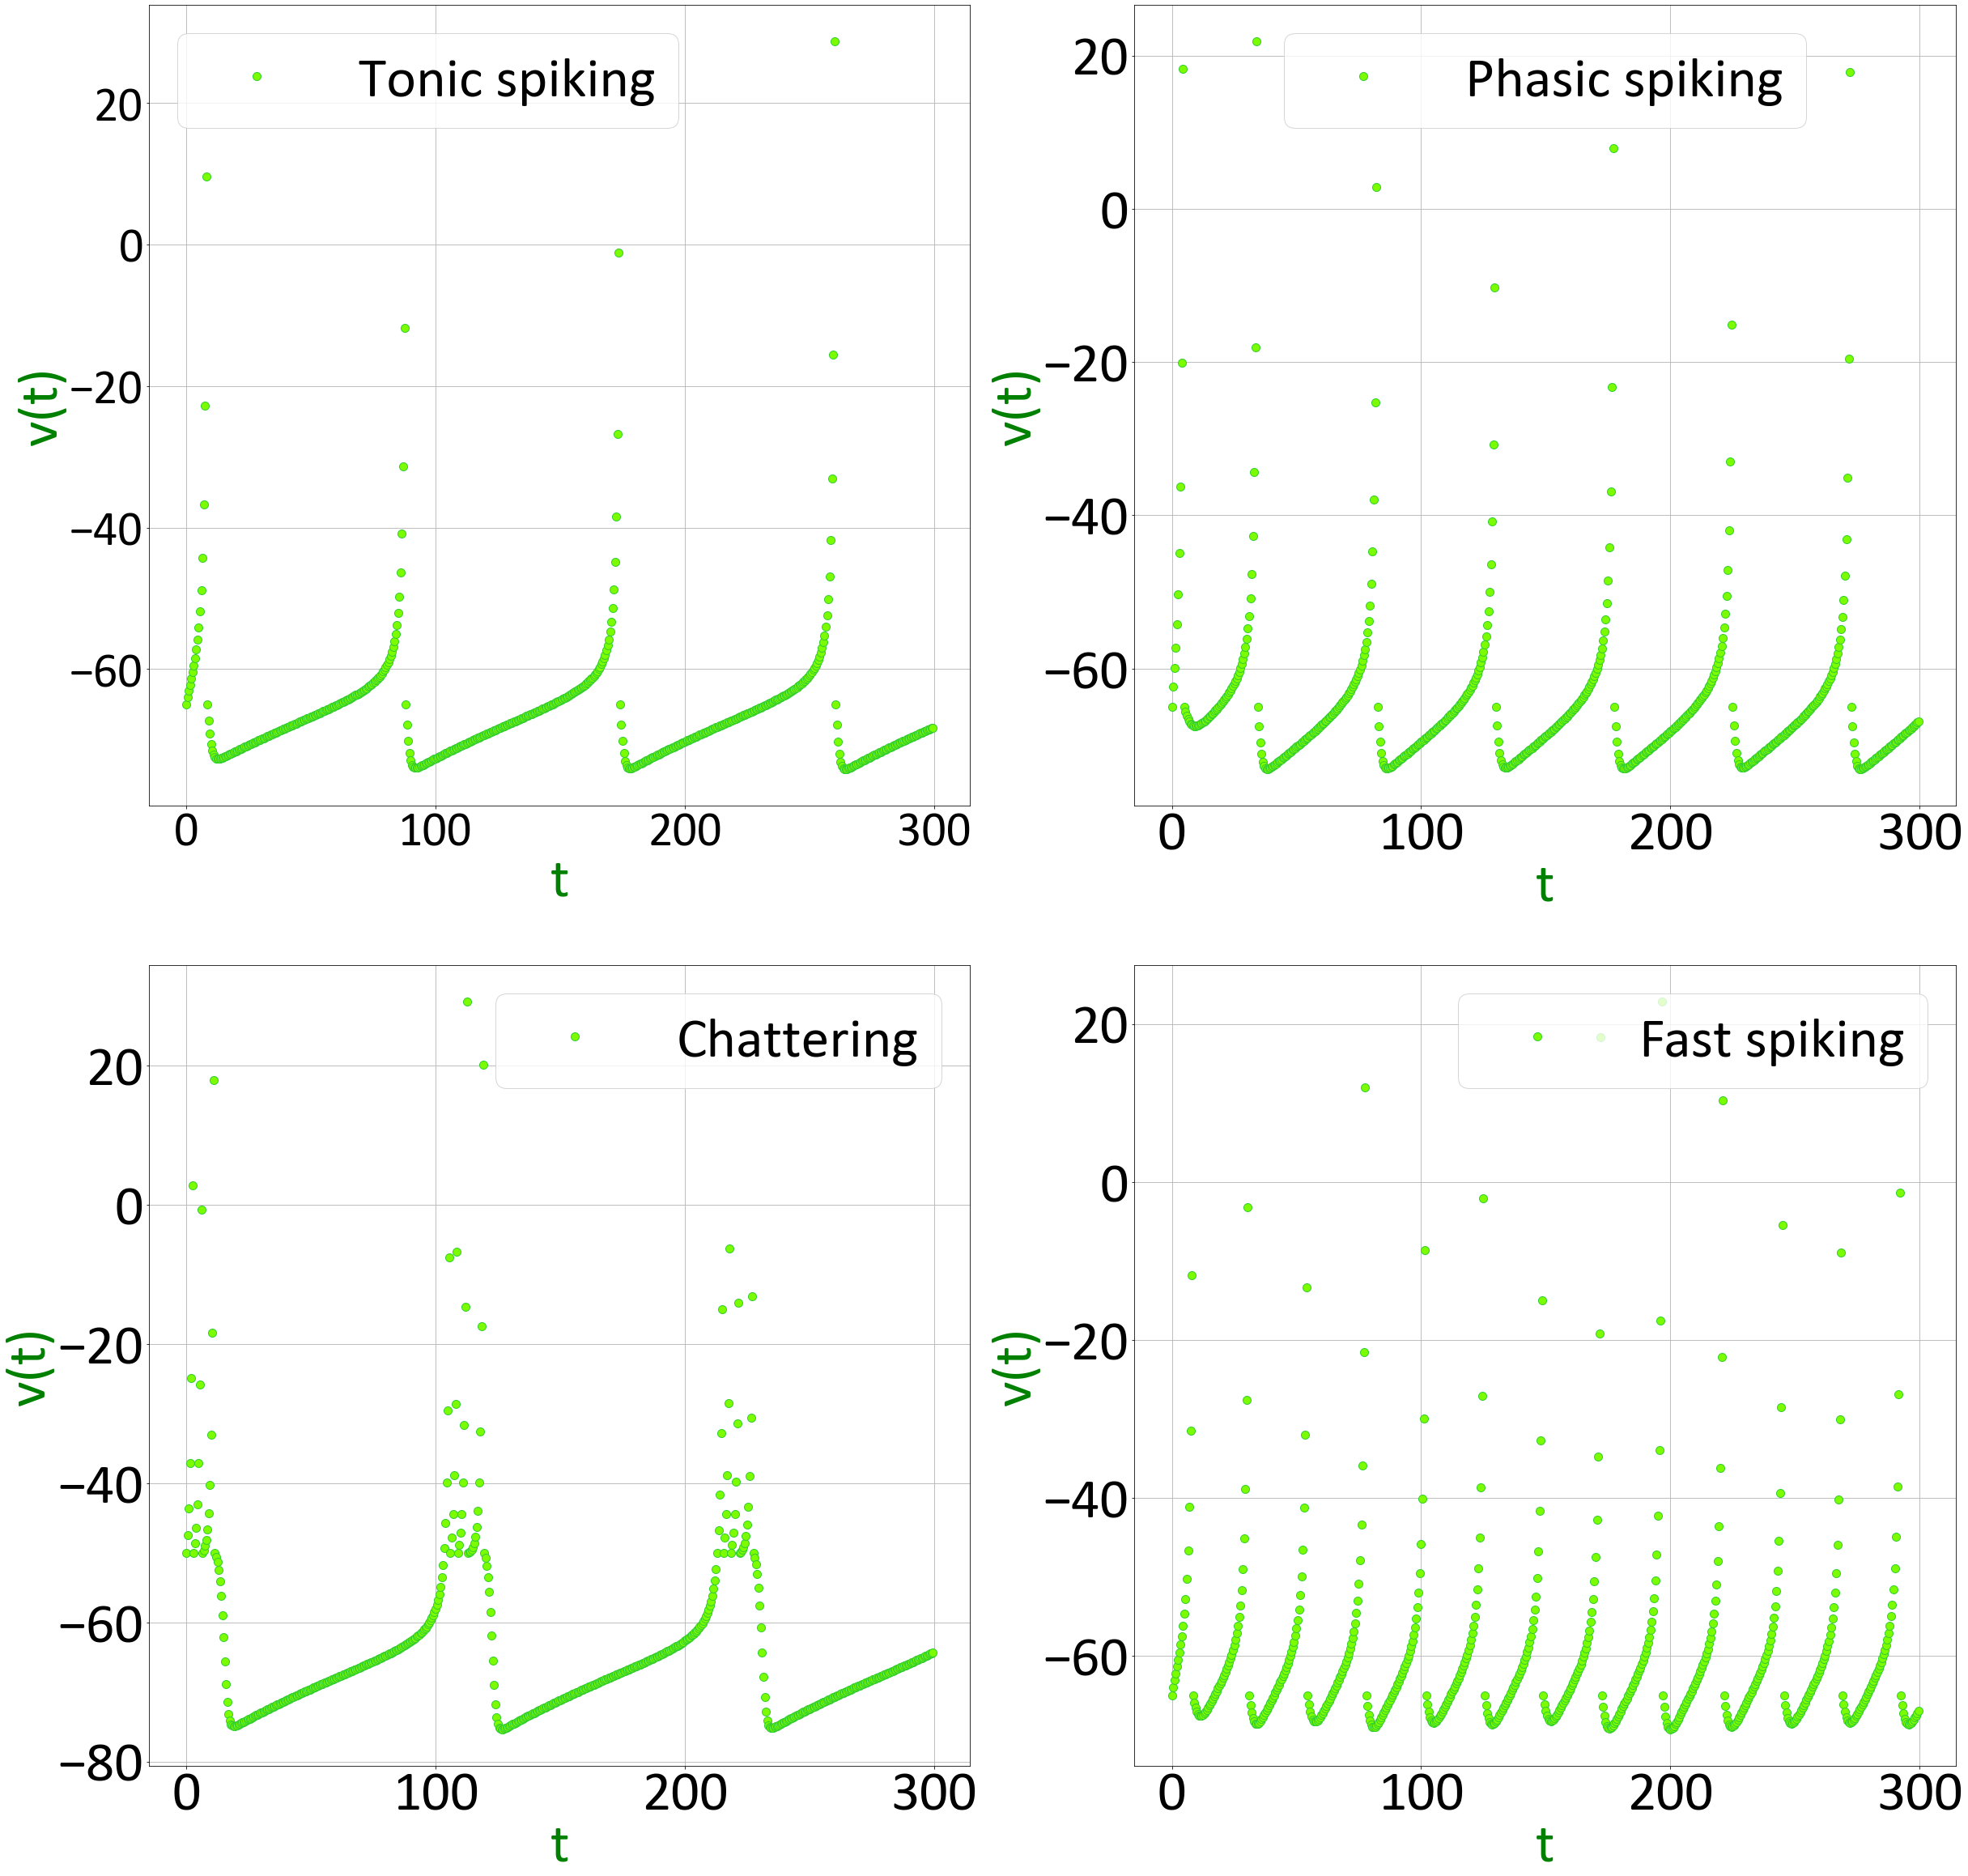

In [928]:
graphic_one(time, euler_, 4, 0, 'v')

Также для явного метода Эйлера выводим и графики, необходимые для анализа работы системы в каждом из 4-х режимов. 

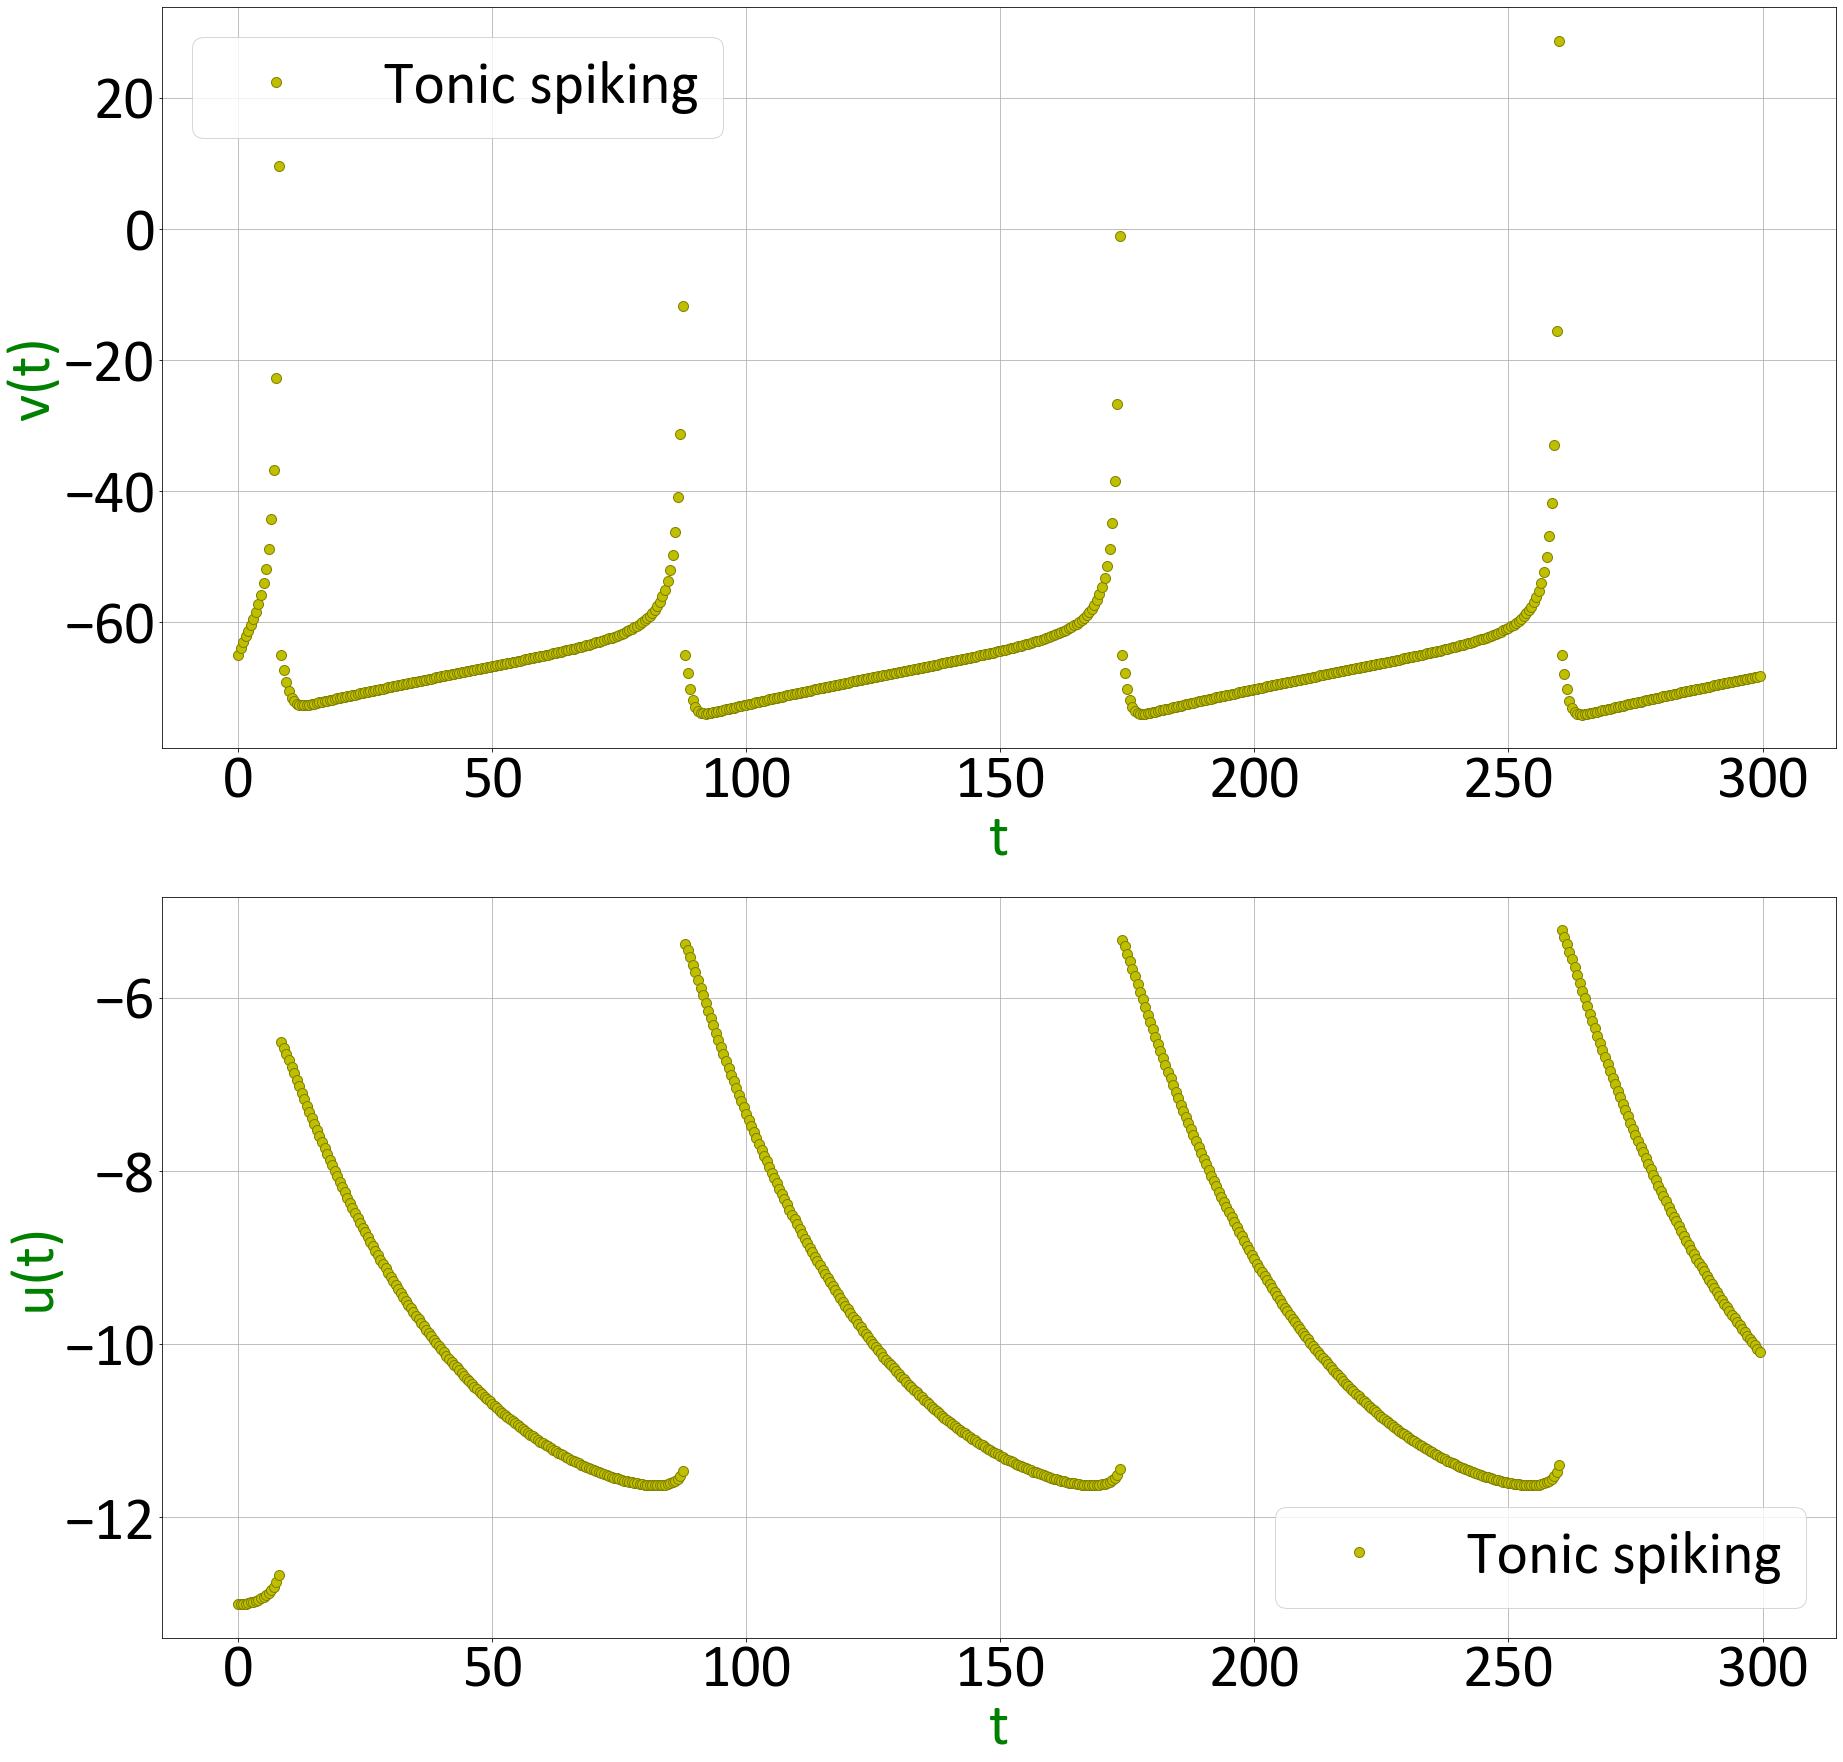

In [920]:
graphic_one_u(time, euler_[0], 7, 0, ['v', 'u'])

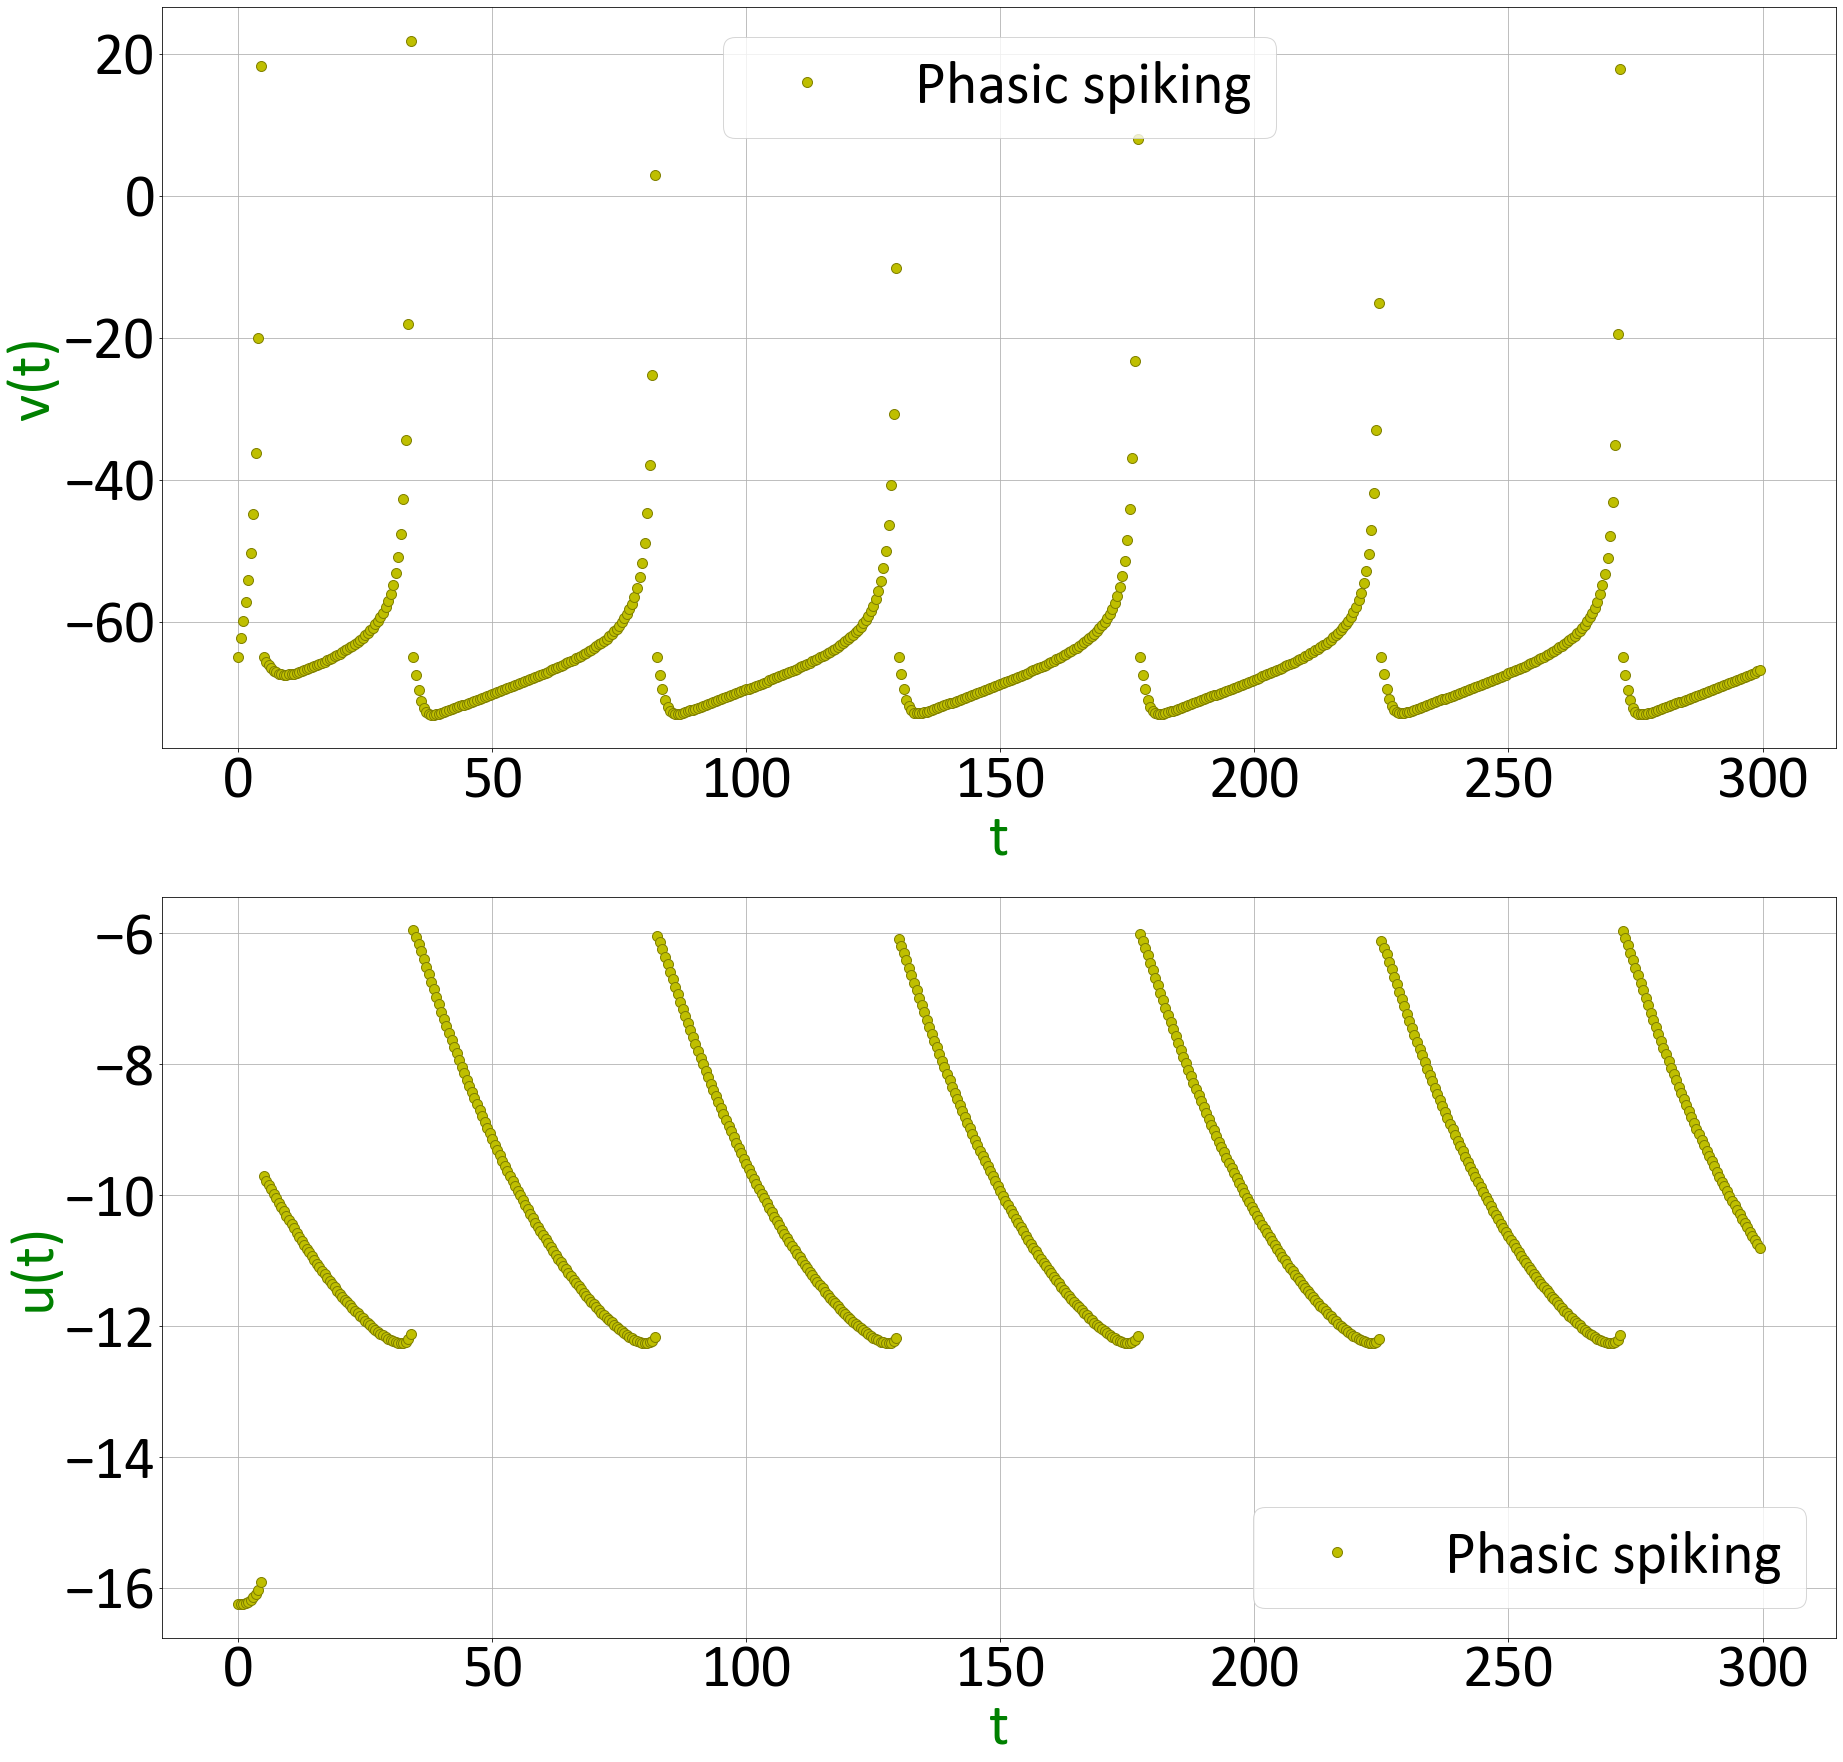

In [922]:
graphic_one_u(time, euler_[1], 8, 1, ['v', 'u'])

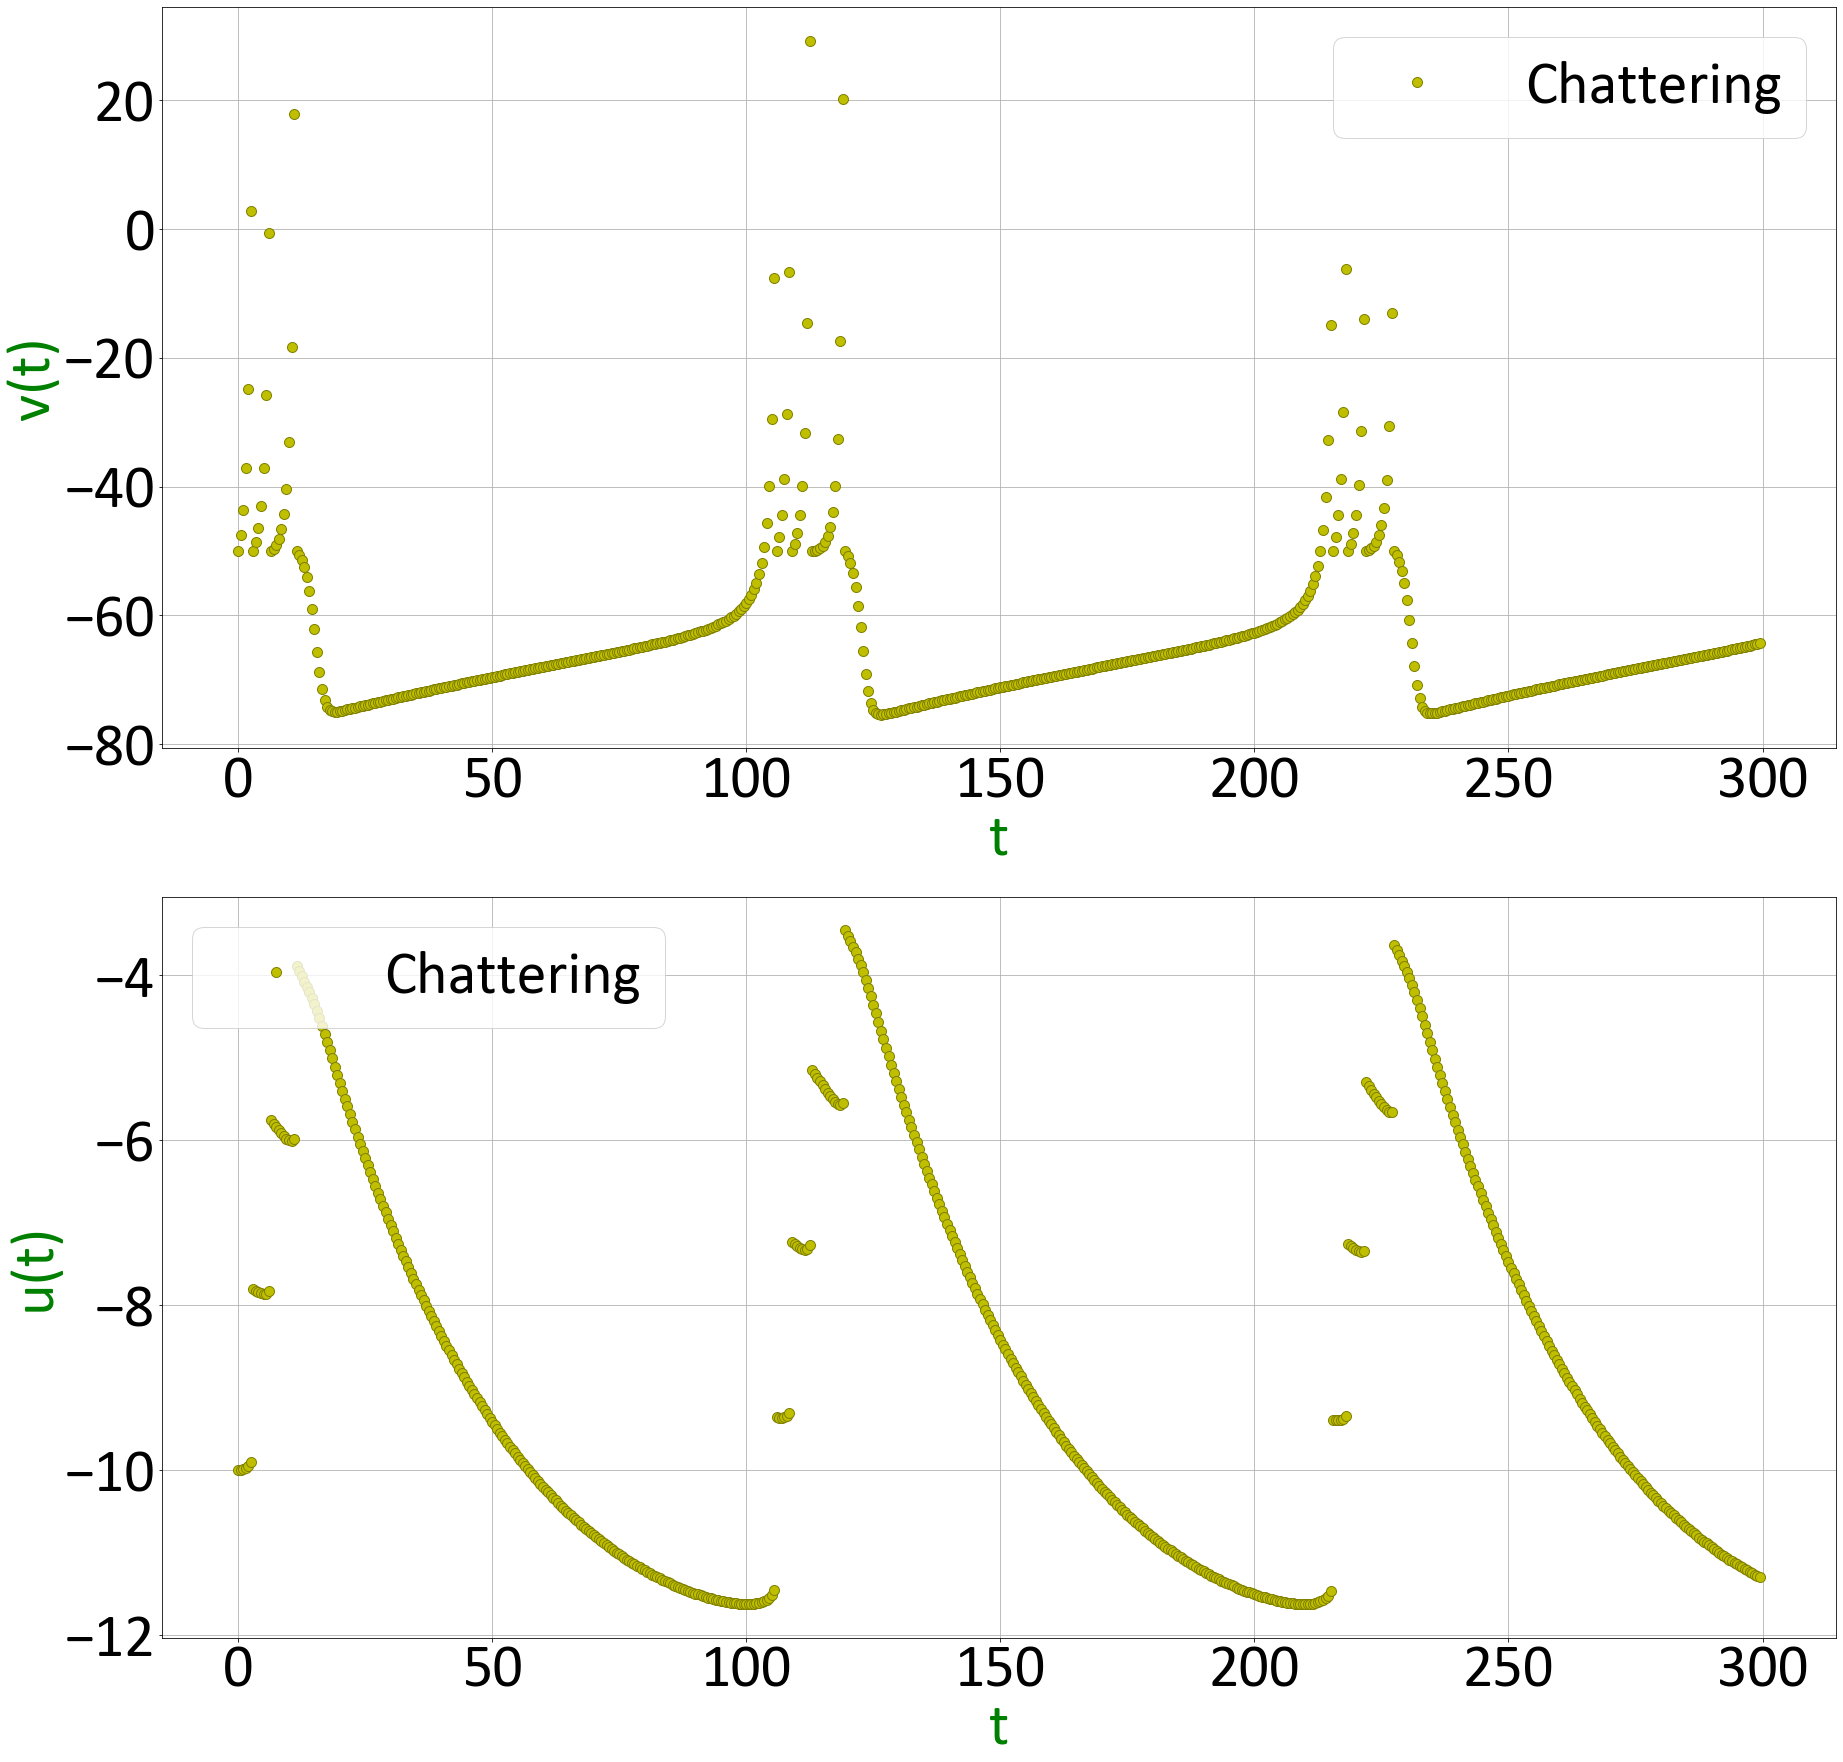

In [923]:
graphic_one_u(time, euler_[2], 9, 2, ['v', 'u'])

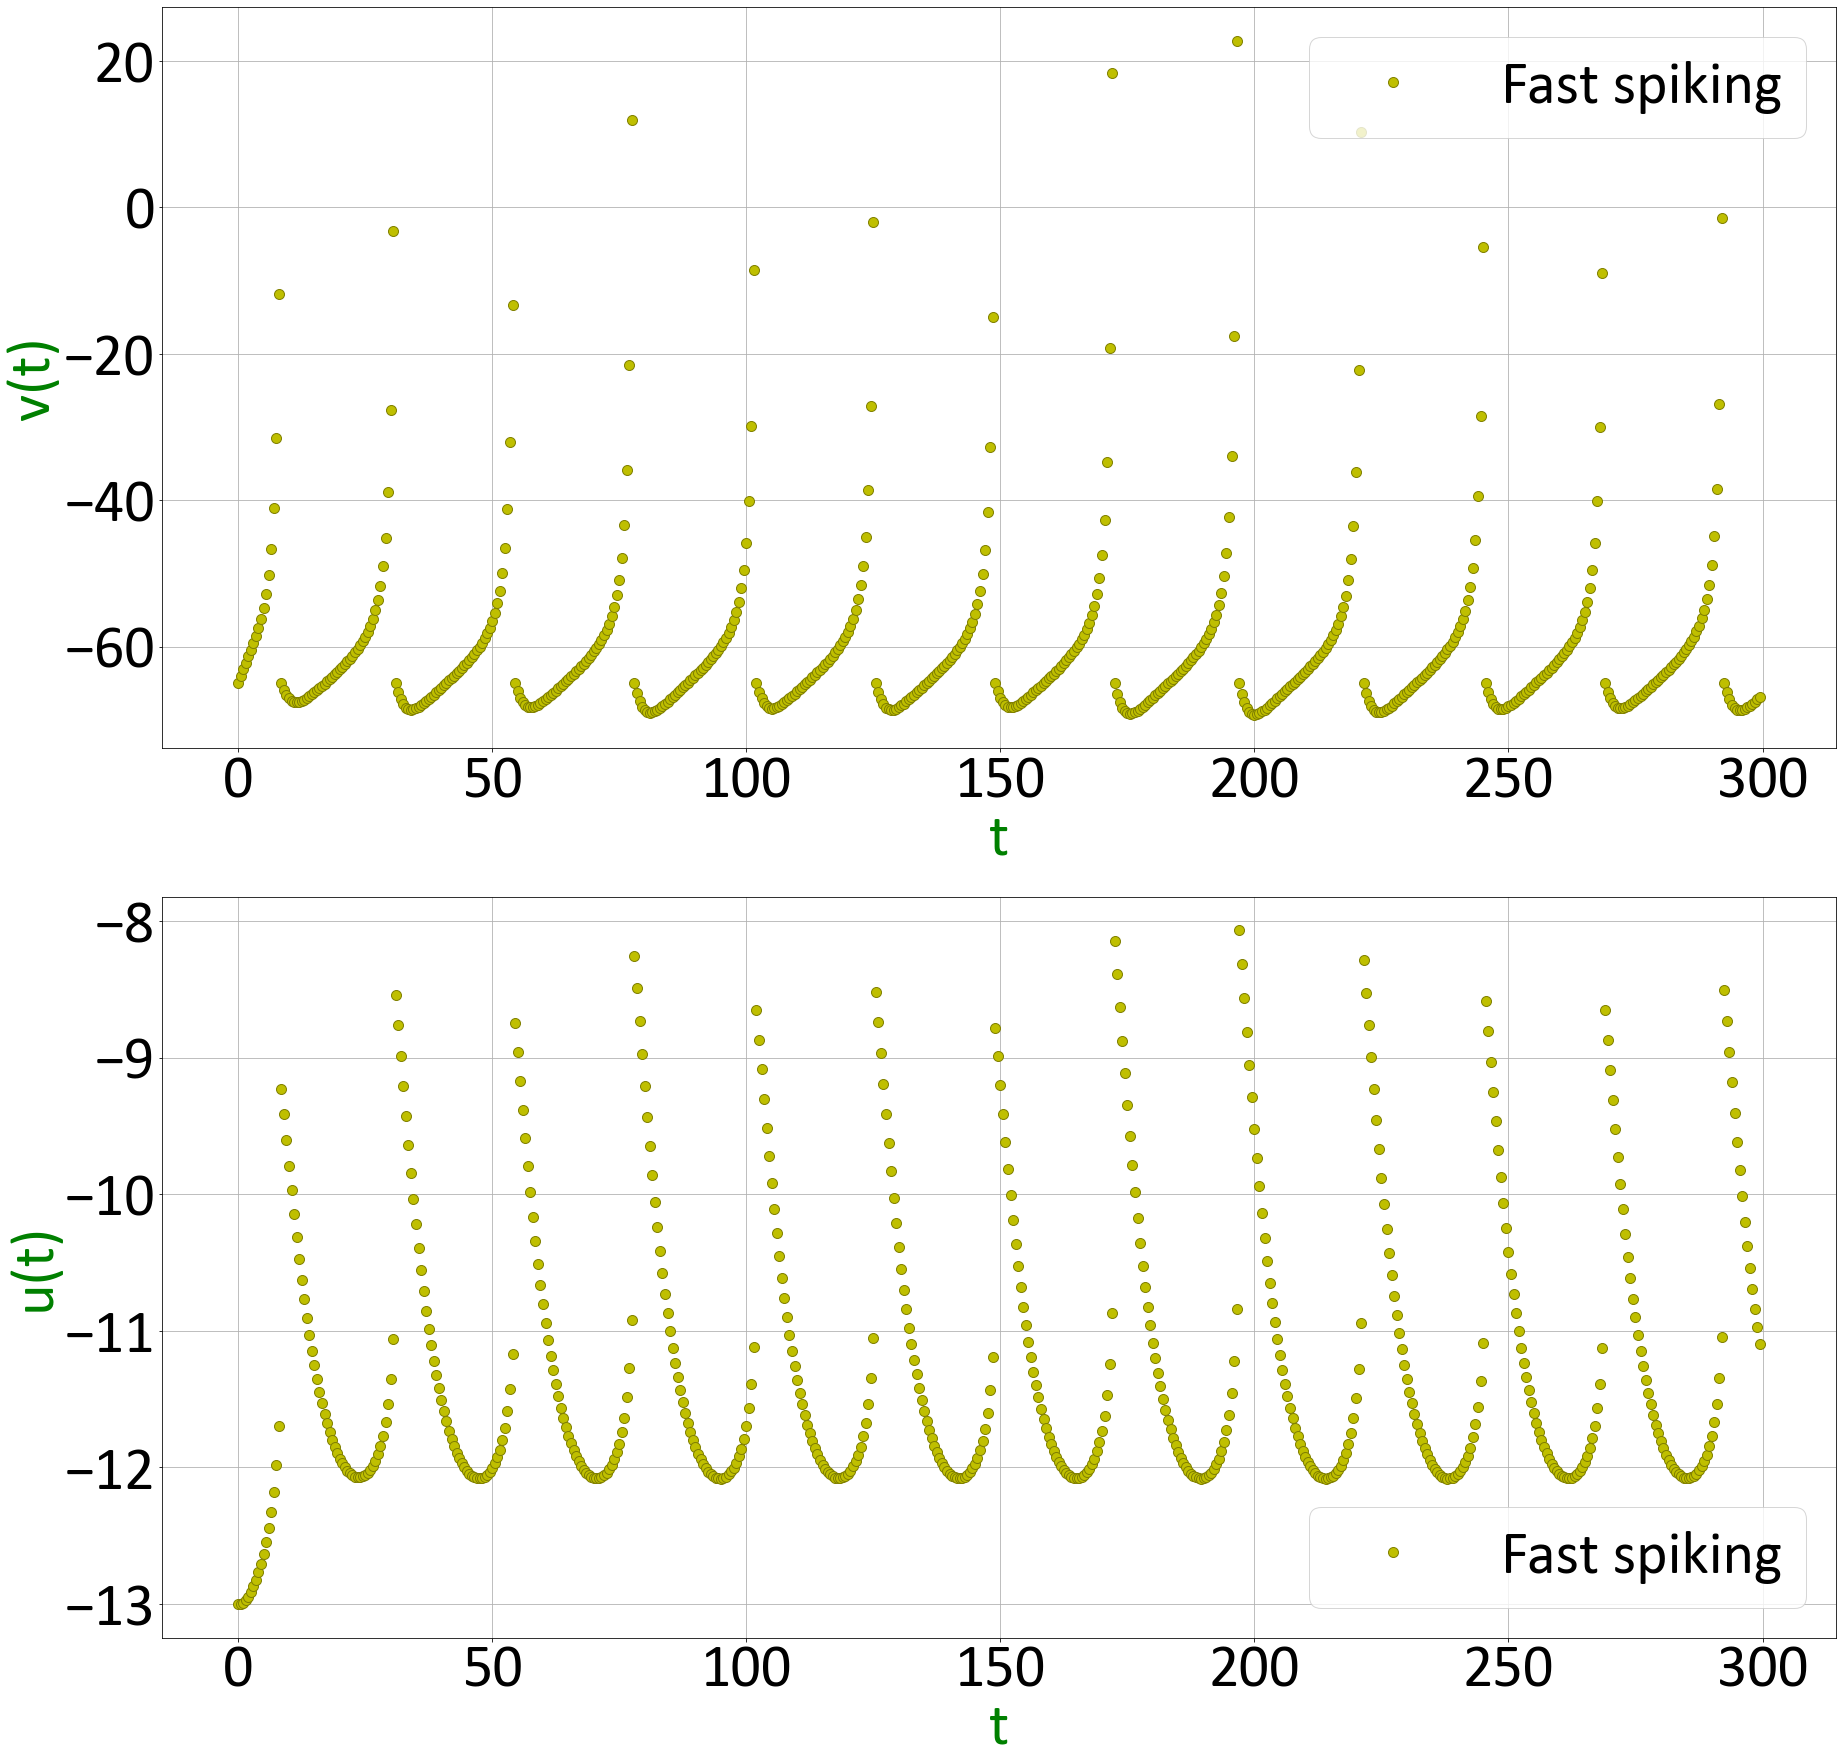

In [924]:
graphic_one_u(time, euler_[3], 10, 3, ['v', 'u'])

Выводим 4 графика для неявного метода Эйлера.

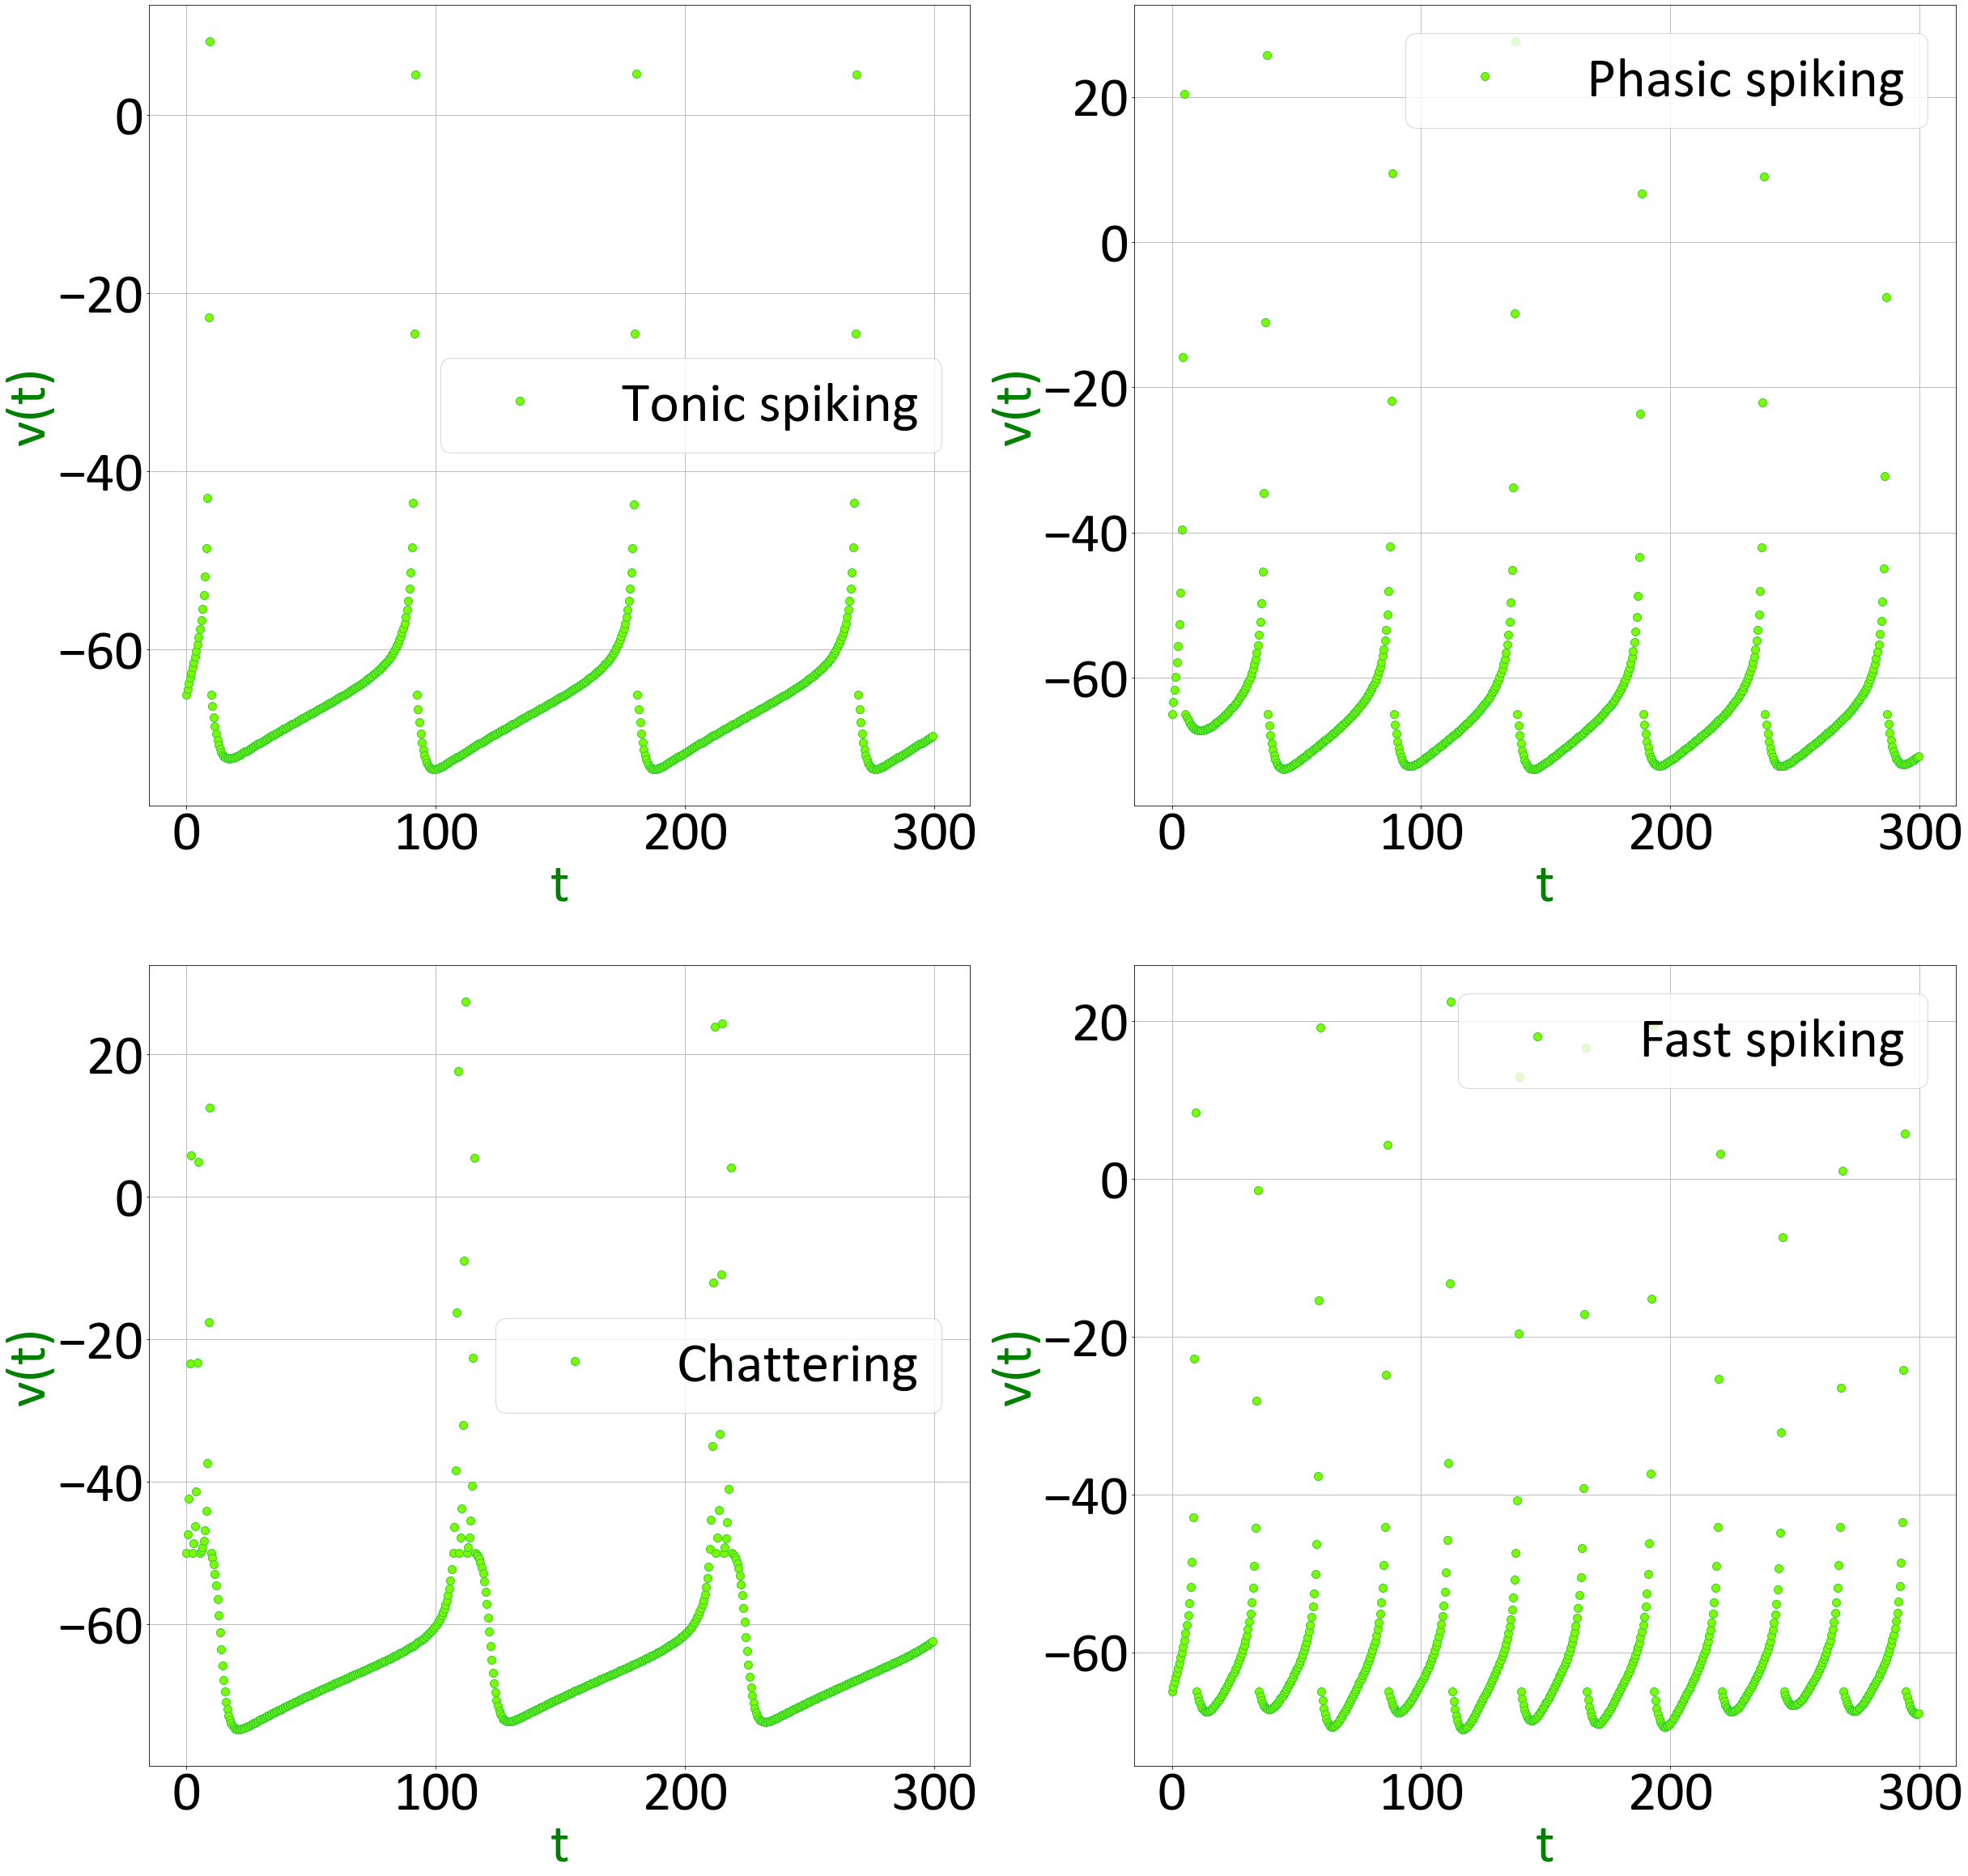

In [929]:
graphic_one(time, imp_euler_, 5, 0, 'v')

И еще 4 графика для метода Рунге-Кутта 4-го порядка.

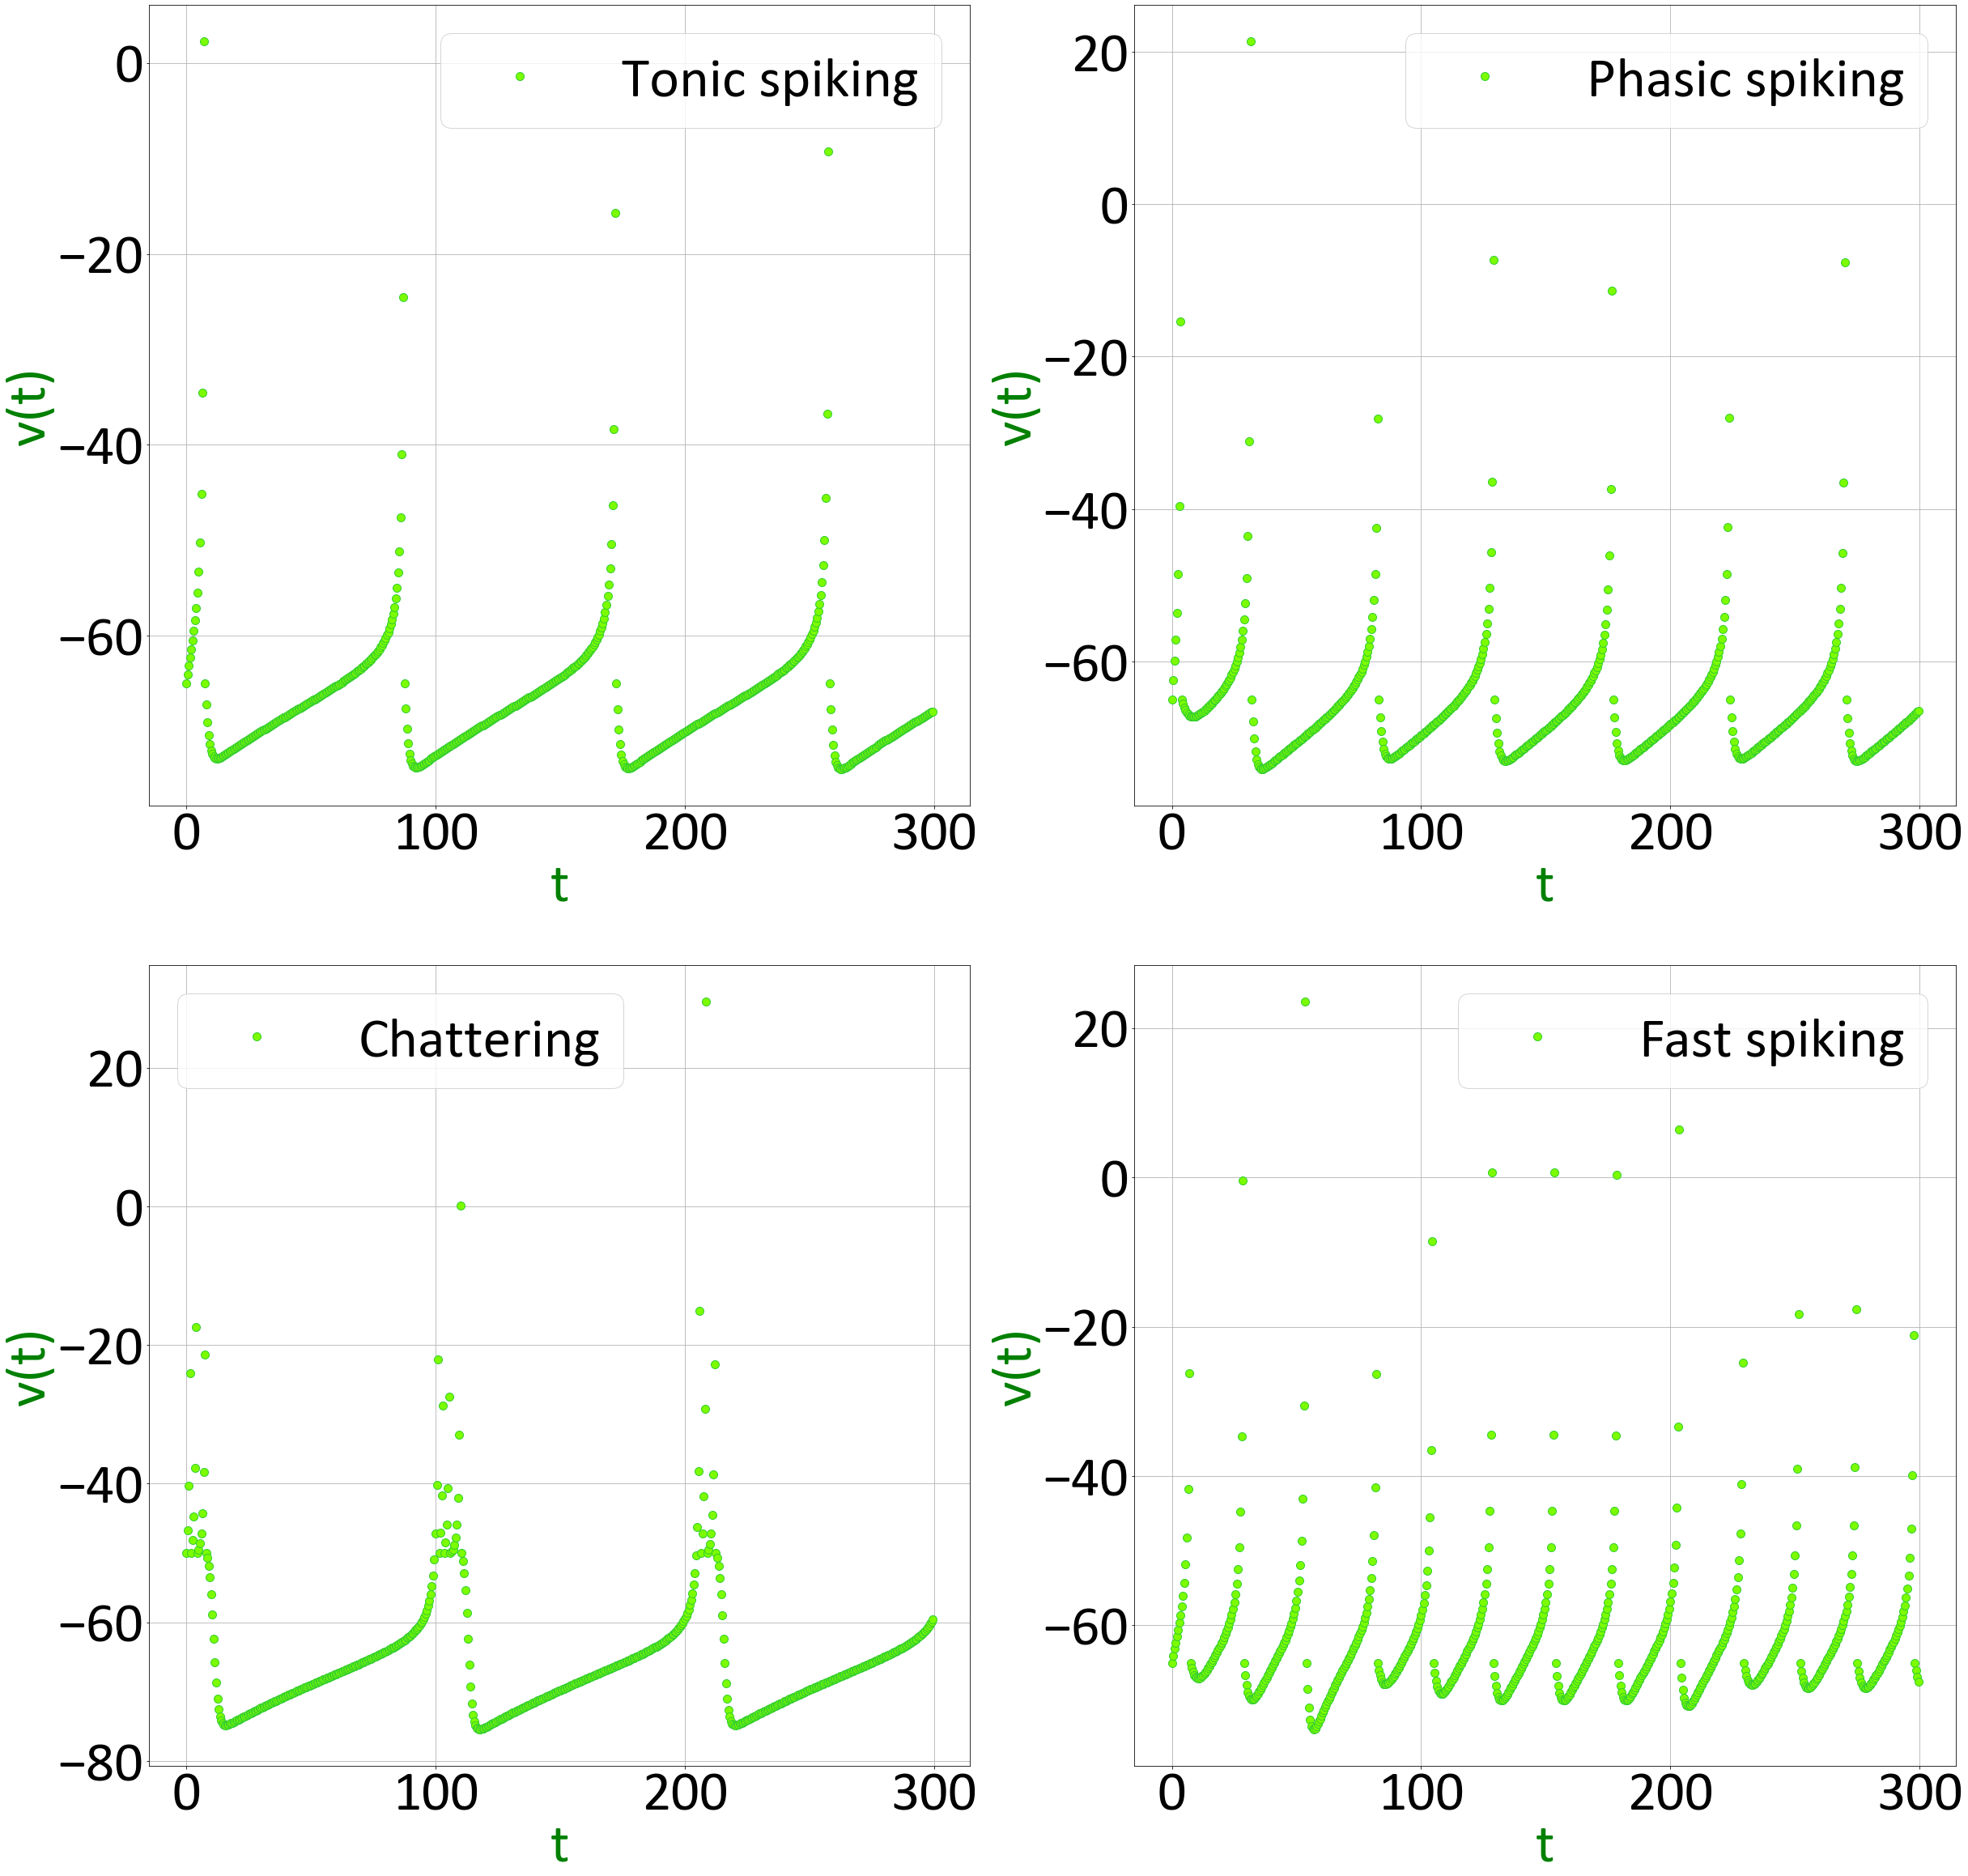

In [930]:
graphic_one(time, kutta_, 6, 0, 'v')

### Продвинутая часть

Для продвинутой части понадобится модуль scipy.stats для генерации случайных величин.

In [1]:
import scipy.stats as sts

In [3]:
a_ex, b_ex = 0.02, 0.2
c_ex = lambda x: -65 +  15 * x ** 2
d_ex = lambda x: 8 -  6 * x ** 2
a_in = lambda x: 0.02 + 0.08 * x
b_in = lambda x: 0.25 - 0.05 * x
c_in, d_in = -65, 2
I_ex = lambda x: 5 * x
I_in = lambda x: 2 * x

In [403]:
def rv(random):
    if random == 'norm':
        return float(sts.norm.rvs(loc = 1/2, scale = 1/12, size = 1))
    if random == 'uniform':
        return float(sts.uniform.rvs(loc = 0, scale = 1, size = 1))
    if random == 'mixture':
        un = sts.uniform.rvs()
        if un <= 1/2:
            return float(sts.norm.rvs(loc = 1/2, scale = 1/12, size = 1))
        else:
            return float(sts.uniform.rvs(loc = 0, scale = 1, size = 1))

In [385]:
def neural_network_params(n, ex_n, random):    
    W = [[0 for i in range(n)] for j in range(n)]
    coef = [[] for i in range(n)]
    I_d = [0 for i in range(n)]
    I_syn = [0 for i in range(n)]
    V = [-65 for i in range(n)]
    U = [-65 * 0.2 for i in range(n)]

    for i in range(ex_n):
        W[i] = sts.uniform.rvs(loc=0, scale=1/2, size=n)
        coef[i] = [a_ex, b_ex, c_ex(rv(random)), d_ex(rv(random))]
        I_d[i] = I_ex(float(sts.uniform.rvs(loc=0, scale=1, size=1)))
        
    for i in range(n - ex_n):
        W[n - 1 - i] = sts.uniform.rvs(loc=-1, scale=1, size=n)
        coef[n - 1 - i] = [a_in(rv(random)), b_in(rv(random)), c_in, d_in]
        I_d[n - 1 - i] = I_in(float(sts.uniform.rvs(loc=0, scale=1, size=1)))
        U[n - 1 - i] = -65 * coef[n - 1 - i][1]
    
    return [W, coef, I_d, I_syn, V, U]

In [951]:
def neur(n, ex_n, random, synapsis = True):
    W, coef, I_d, I_syn, V, U = neural_network_params(n, ex_n, random)
    t_pulse = []        # список, в котором хранятся значения времени, 
                        # когда произошел импульс
    id_pulse = []       # список, в котором хранятся номера нейронов, 
                        # в которых произошел импульс
    buf_pulse = []      # список, в котором хранятся номера нейронов, 
                        # в которых произошел импульс в данный момент t
    
    for t in np.arange(h, 1005, h):
        buf_pulse = []
        for k in range(n):
            V[k] = V[k] + h * (0.04 * V[k] ** 2 + 5 * V[k]            # явный метод Эйлера для системы ОДУ
                               + 140 - U[k] + I_syn[k] + I_d[k])      
            U[k] = U[k] + h * coef[k] * (coef[k] * V[k] - U[k])       # явный метод Эйлера для системы ОДУ
            I_syn[k] = 0                   # синаптические токи обнуляются

            if V[k] >= 30:                 # если произошел импульс
                t_pulse.append(t)          # добавляется время, когда произошел импульс
                id_pulse.append(k)         # добавляется нейрон, в котором произошел импульс
                buf_pulse.append(k)
                V[k] = coef[k][2]
                U[k] += coef[k][3]   
                
        if synapsis:                           # если данная модель учитывает синаптические токи
            for x in buf_pulse:
                for k in range(n):
                    if k not in buf_pulse:
                        I_syn[k] += W[x][k]    # синаптические токи суммируются 
                                               # от всех нейронов,  
                                               # в которых произошел импульс
                        
    return [t_pulse, id_pulse]

Функция для вывода многомерных временных рядов.

In [757]:
def neur_graph(pulse, p):
    fig = plt.figure(figsize=(40, 40))
    plt.xlabel('t', fontsize=60, color='green')
    plt.ylabel('neuron', fontsize=60, color='green')
    plt.rcParams.update({'font.size': 60}) 
    plt.grid(True)
    plt.plot(pulse[0], pulse[1], color='darkolivegreen', linewidth = 0, 
             marker = 'o', markersize = 10, 
             markerfacecolor = 'mediumseagreen') 
    plt.savefig(f'{p}.svg')

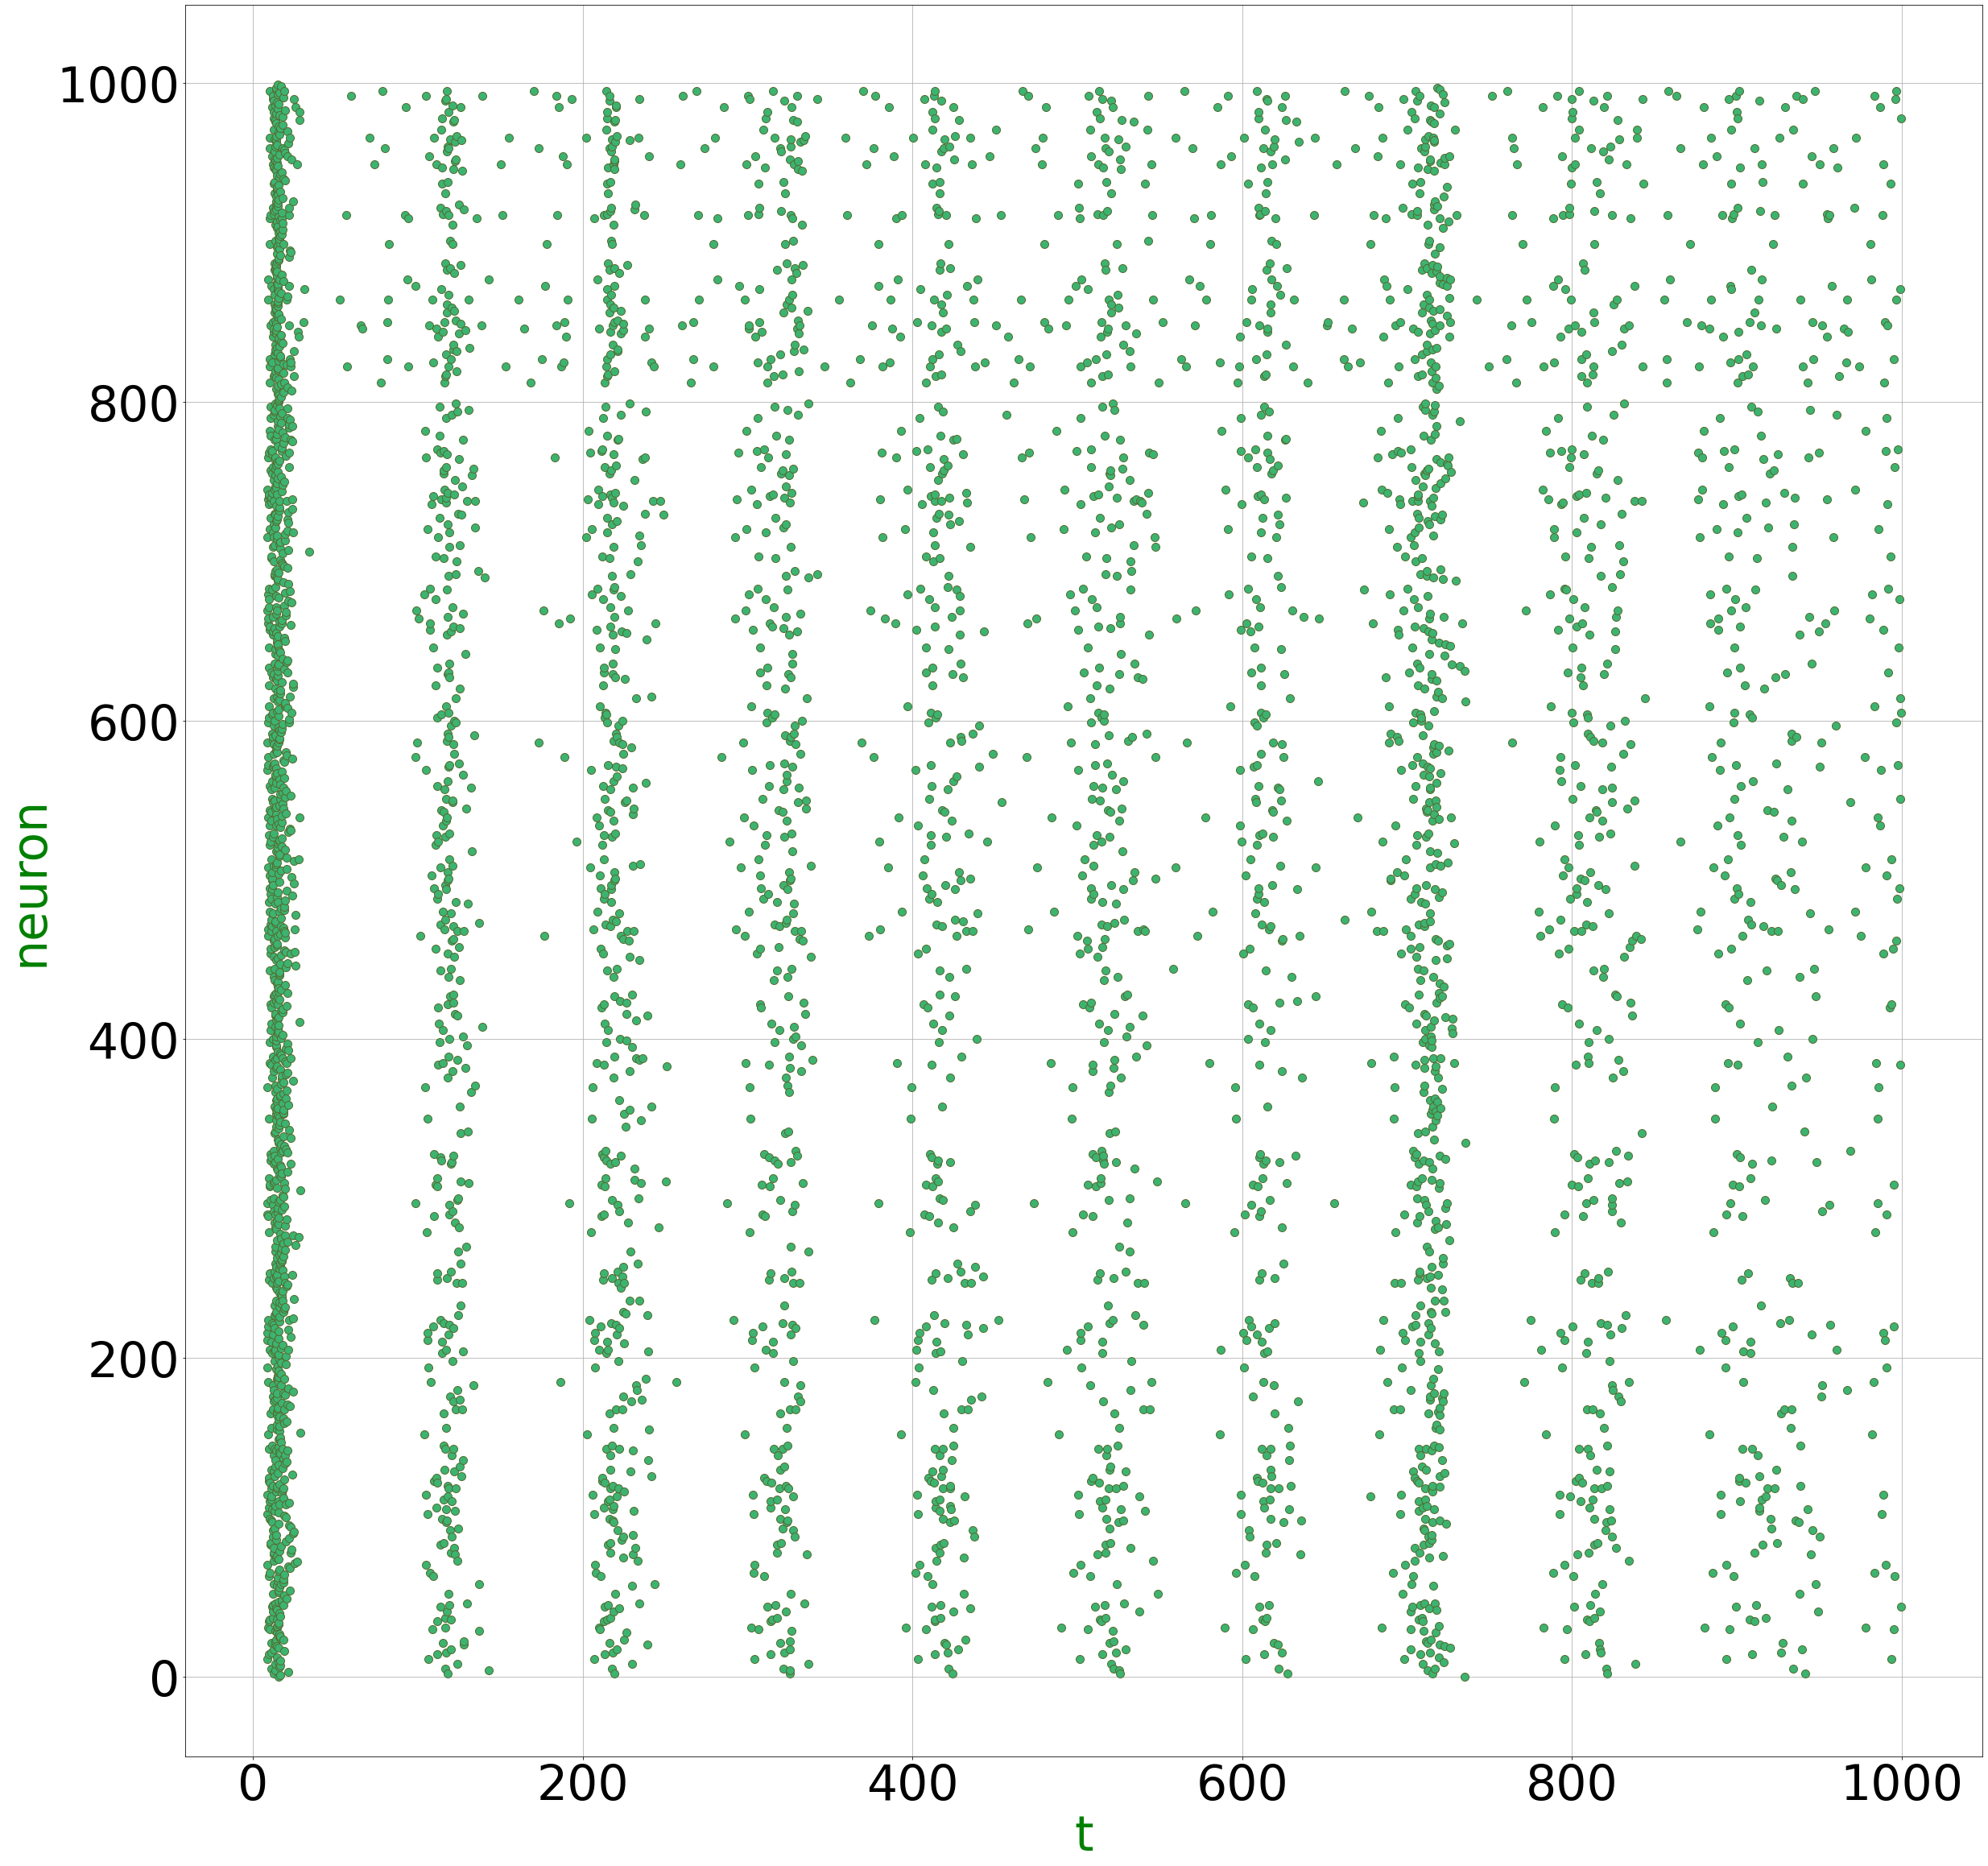

In [758]:
neur_graph(neur(1000, 800, 'uniform'), 'u1')

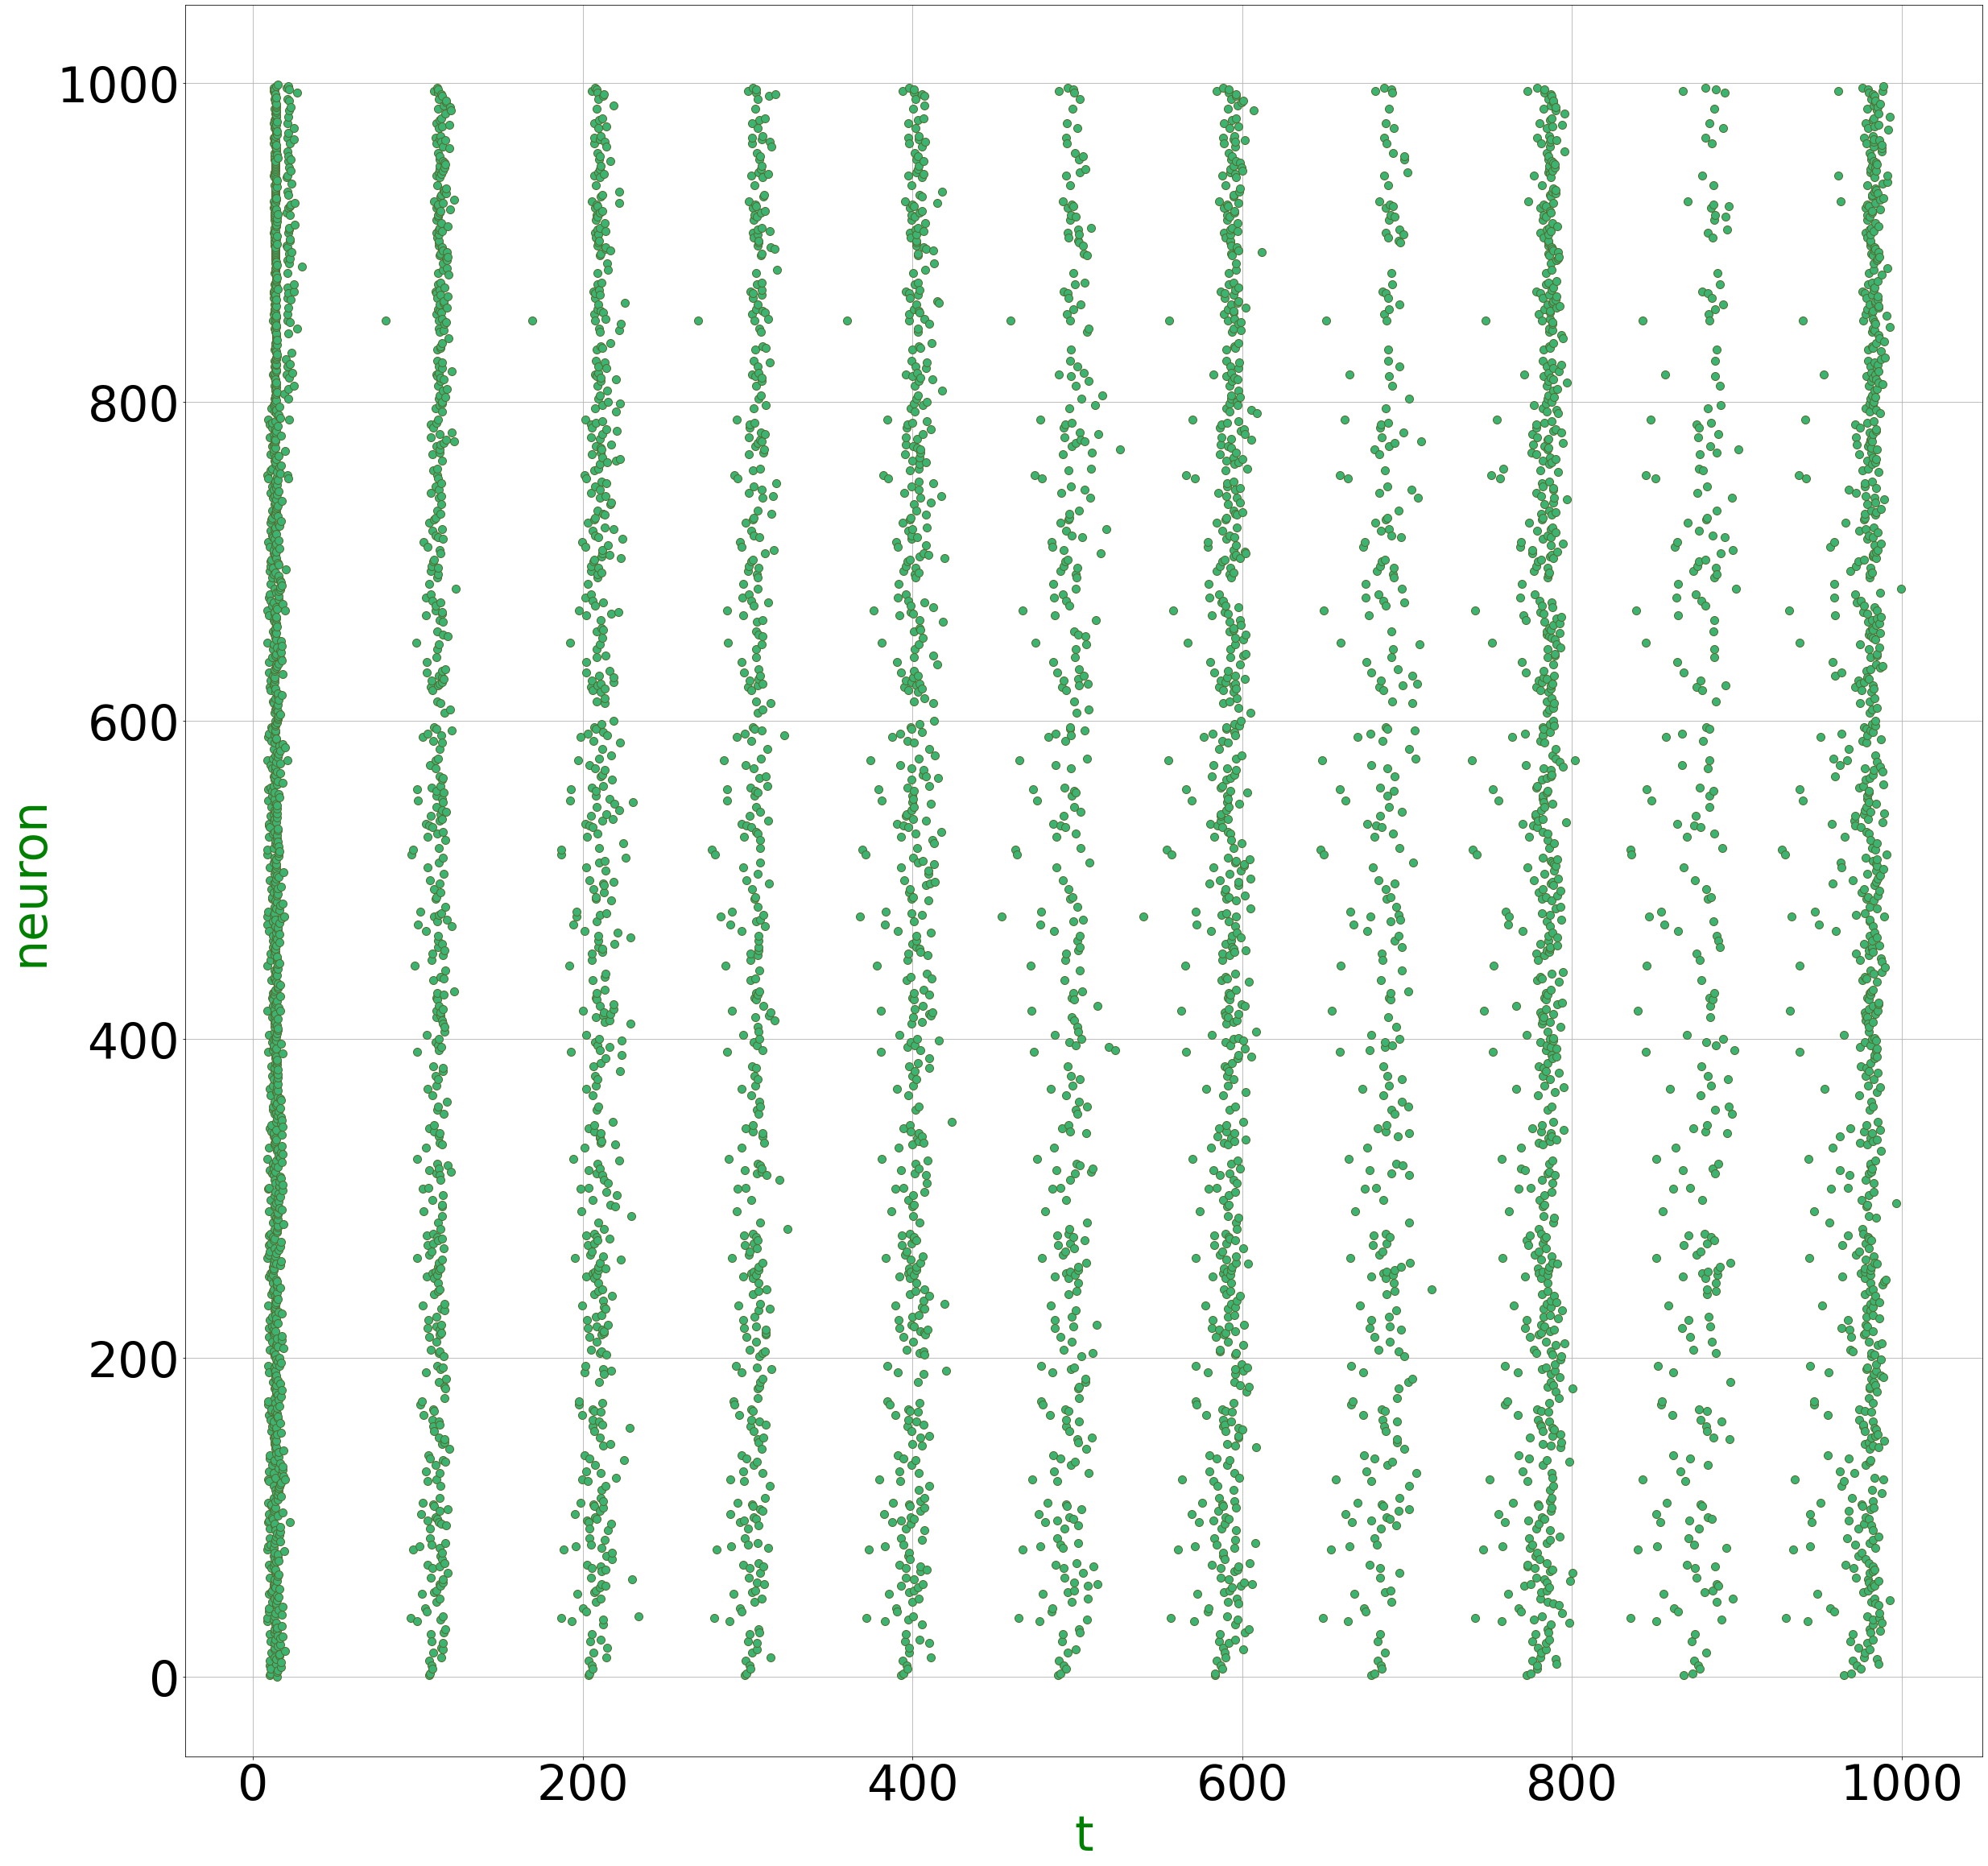

In [759]:
neur_graph(neur(1000, 800, 'norm'), 'n1')

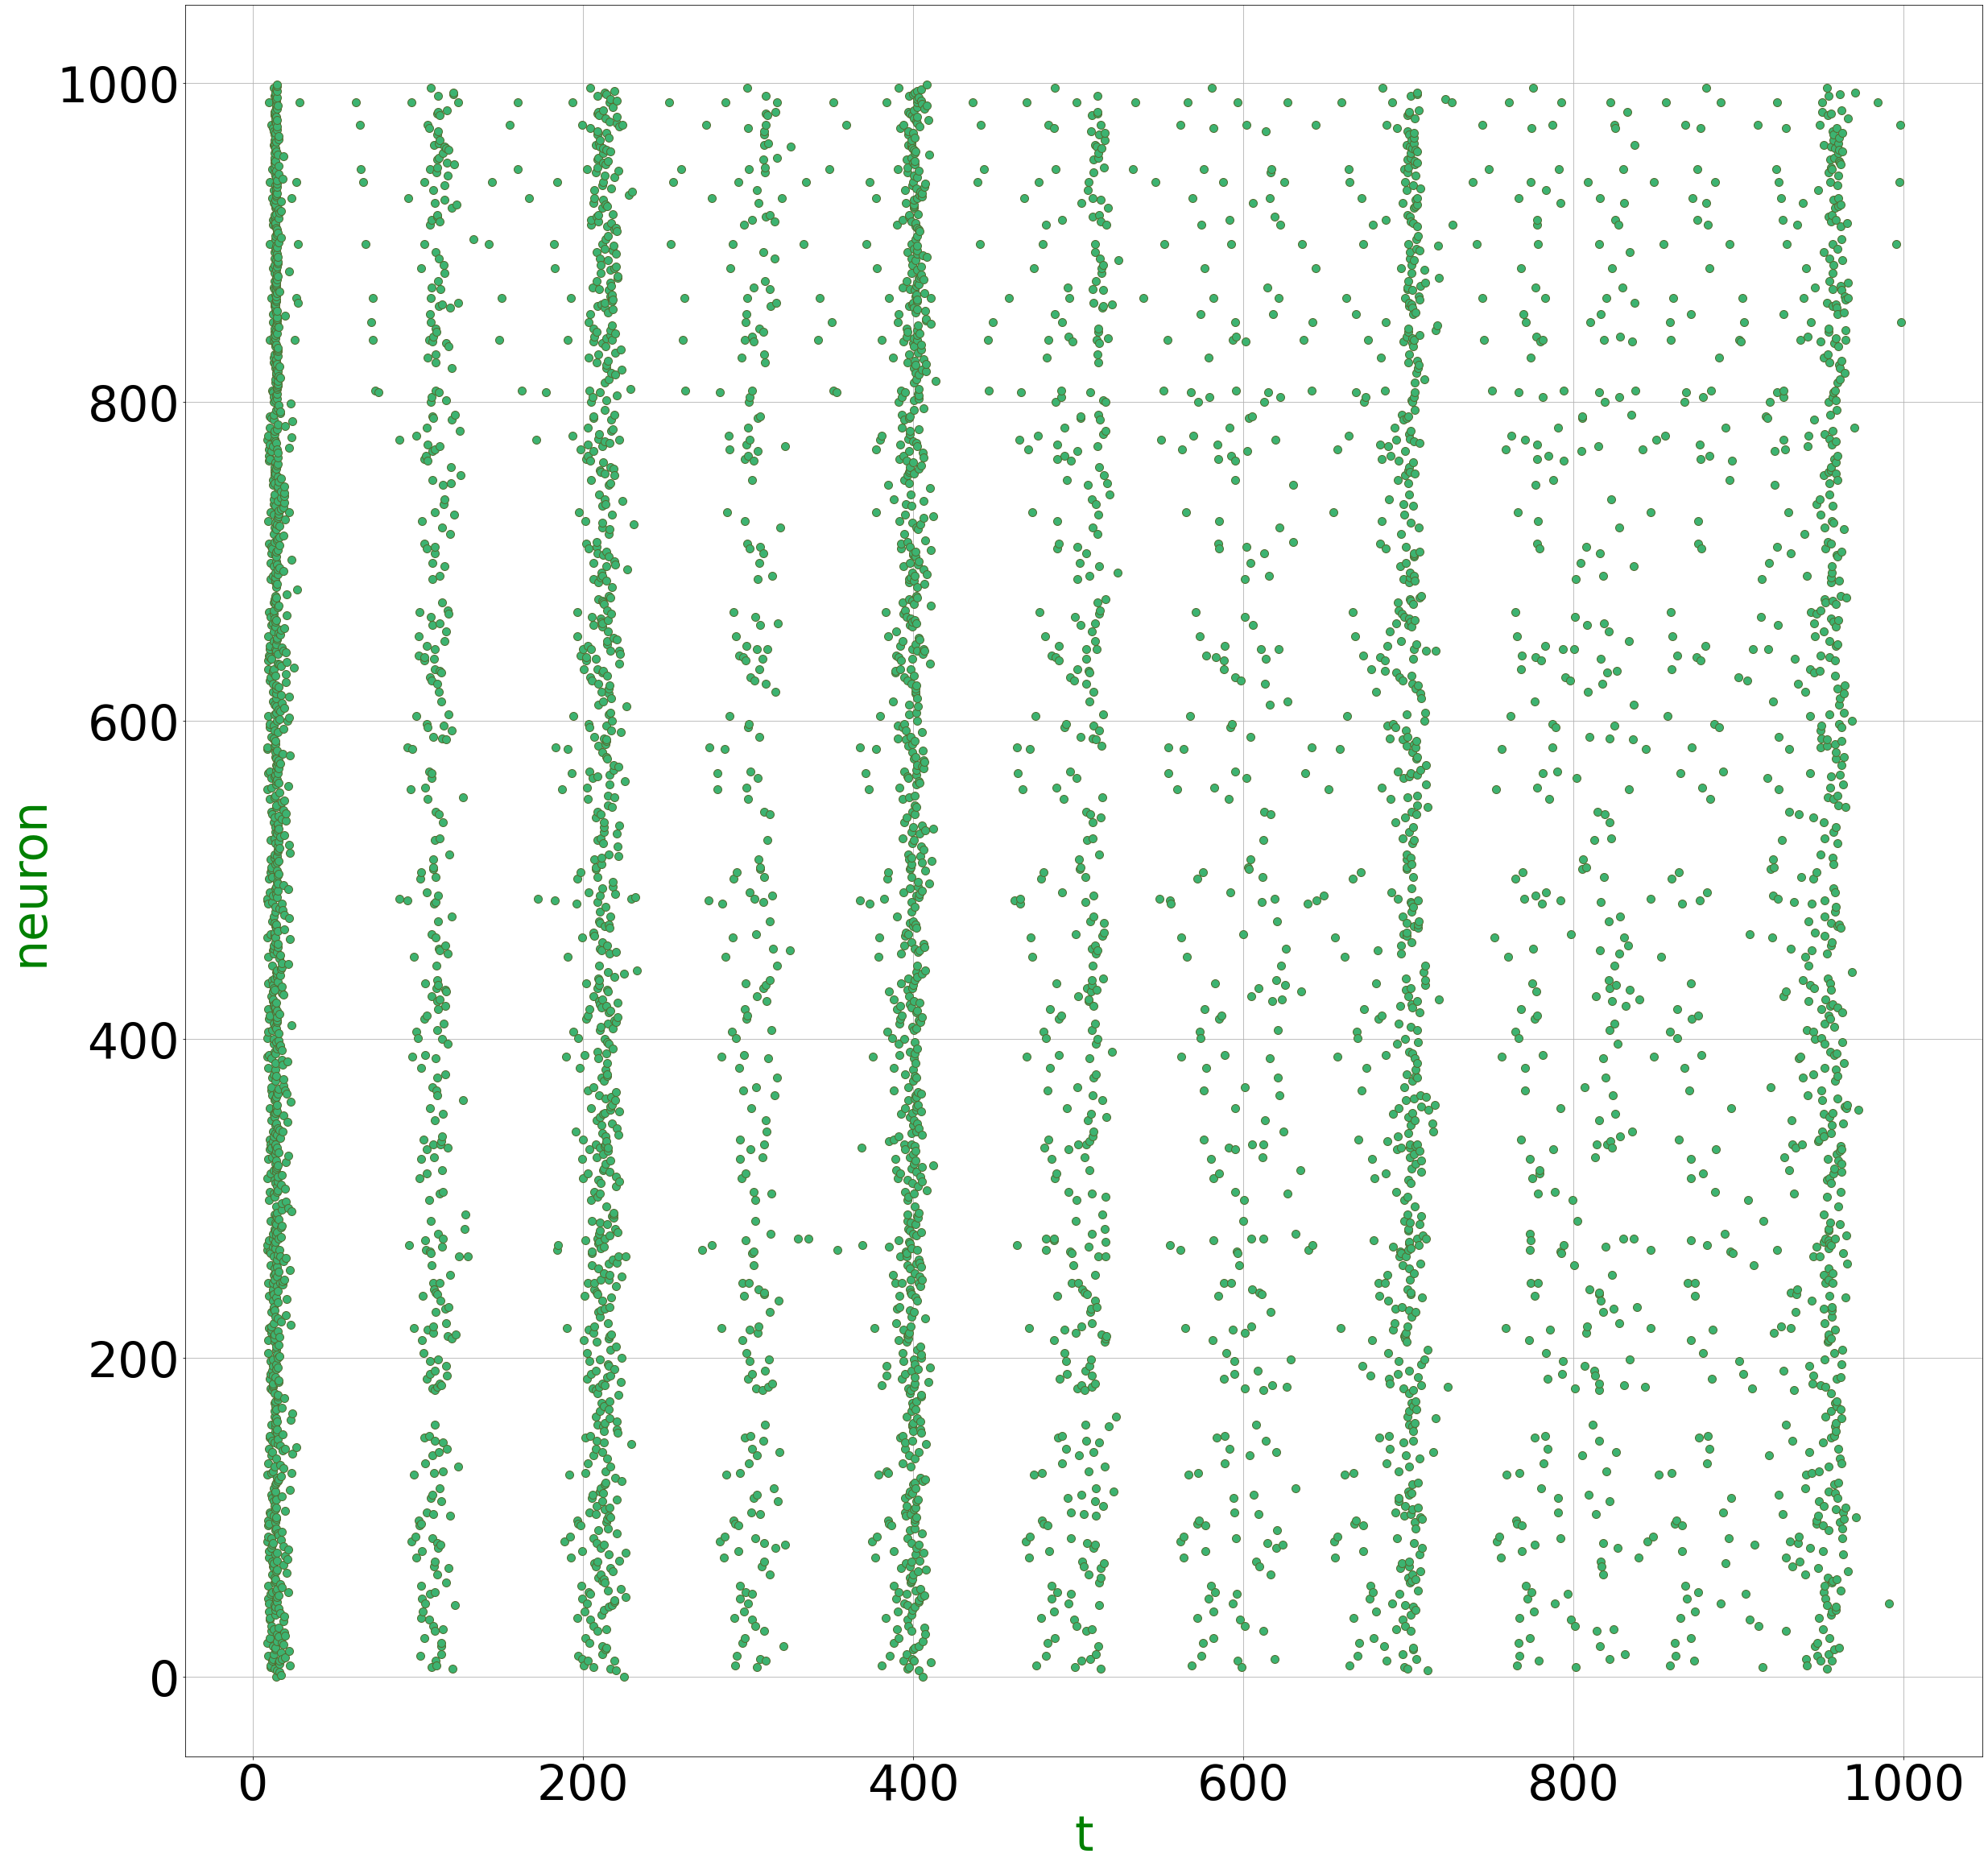

In [760]:
neur_graph(neur(1000, 800, 'mixture'), 'm1')

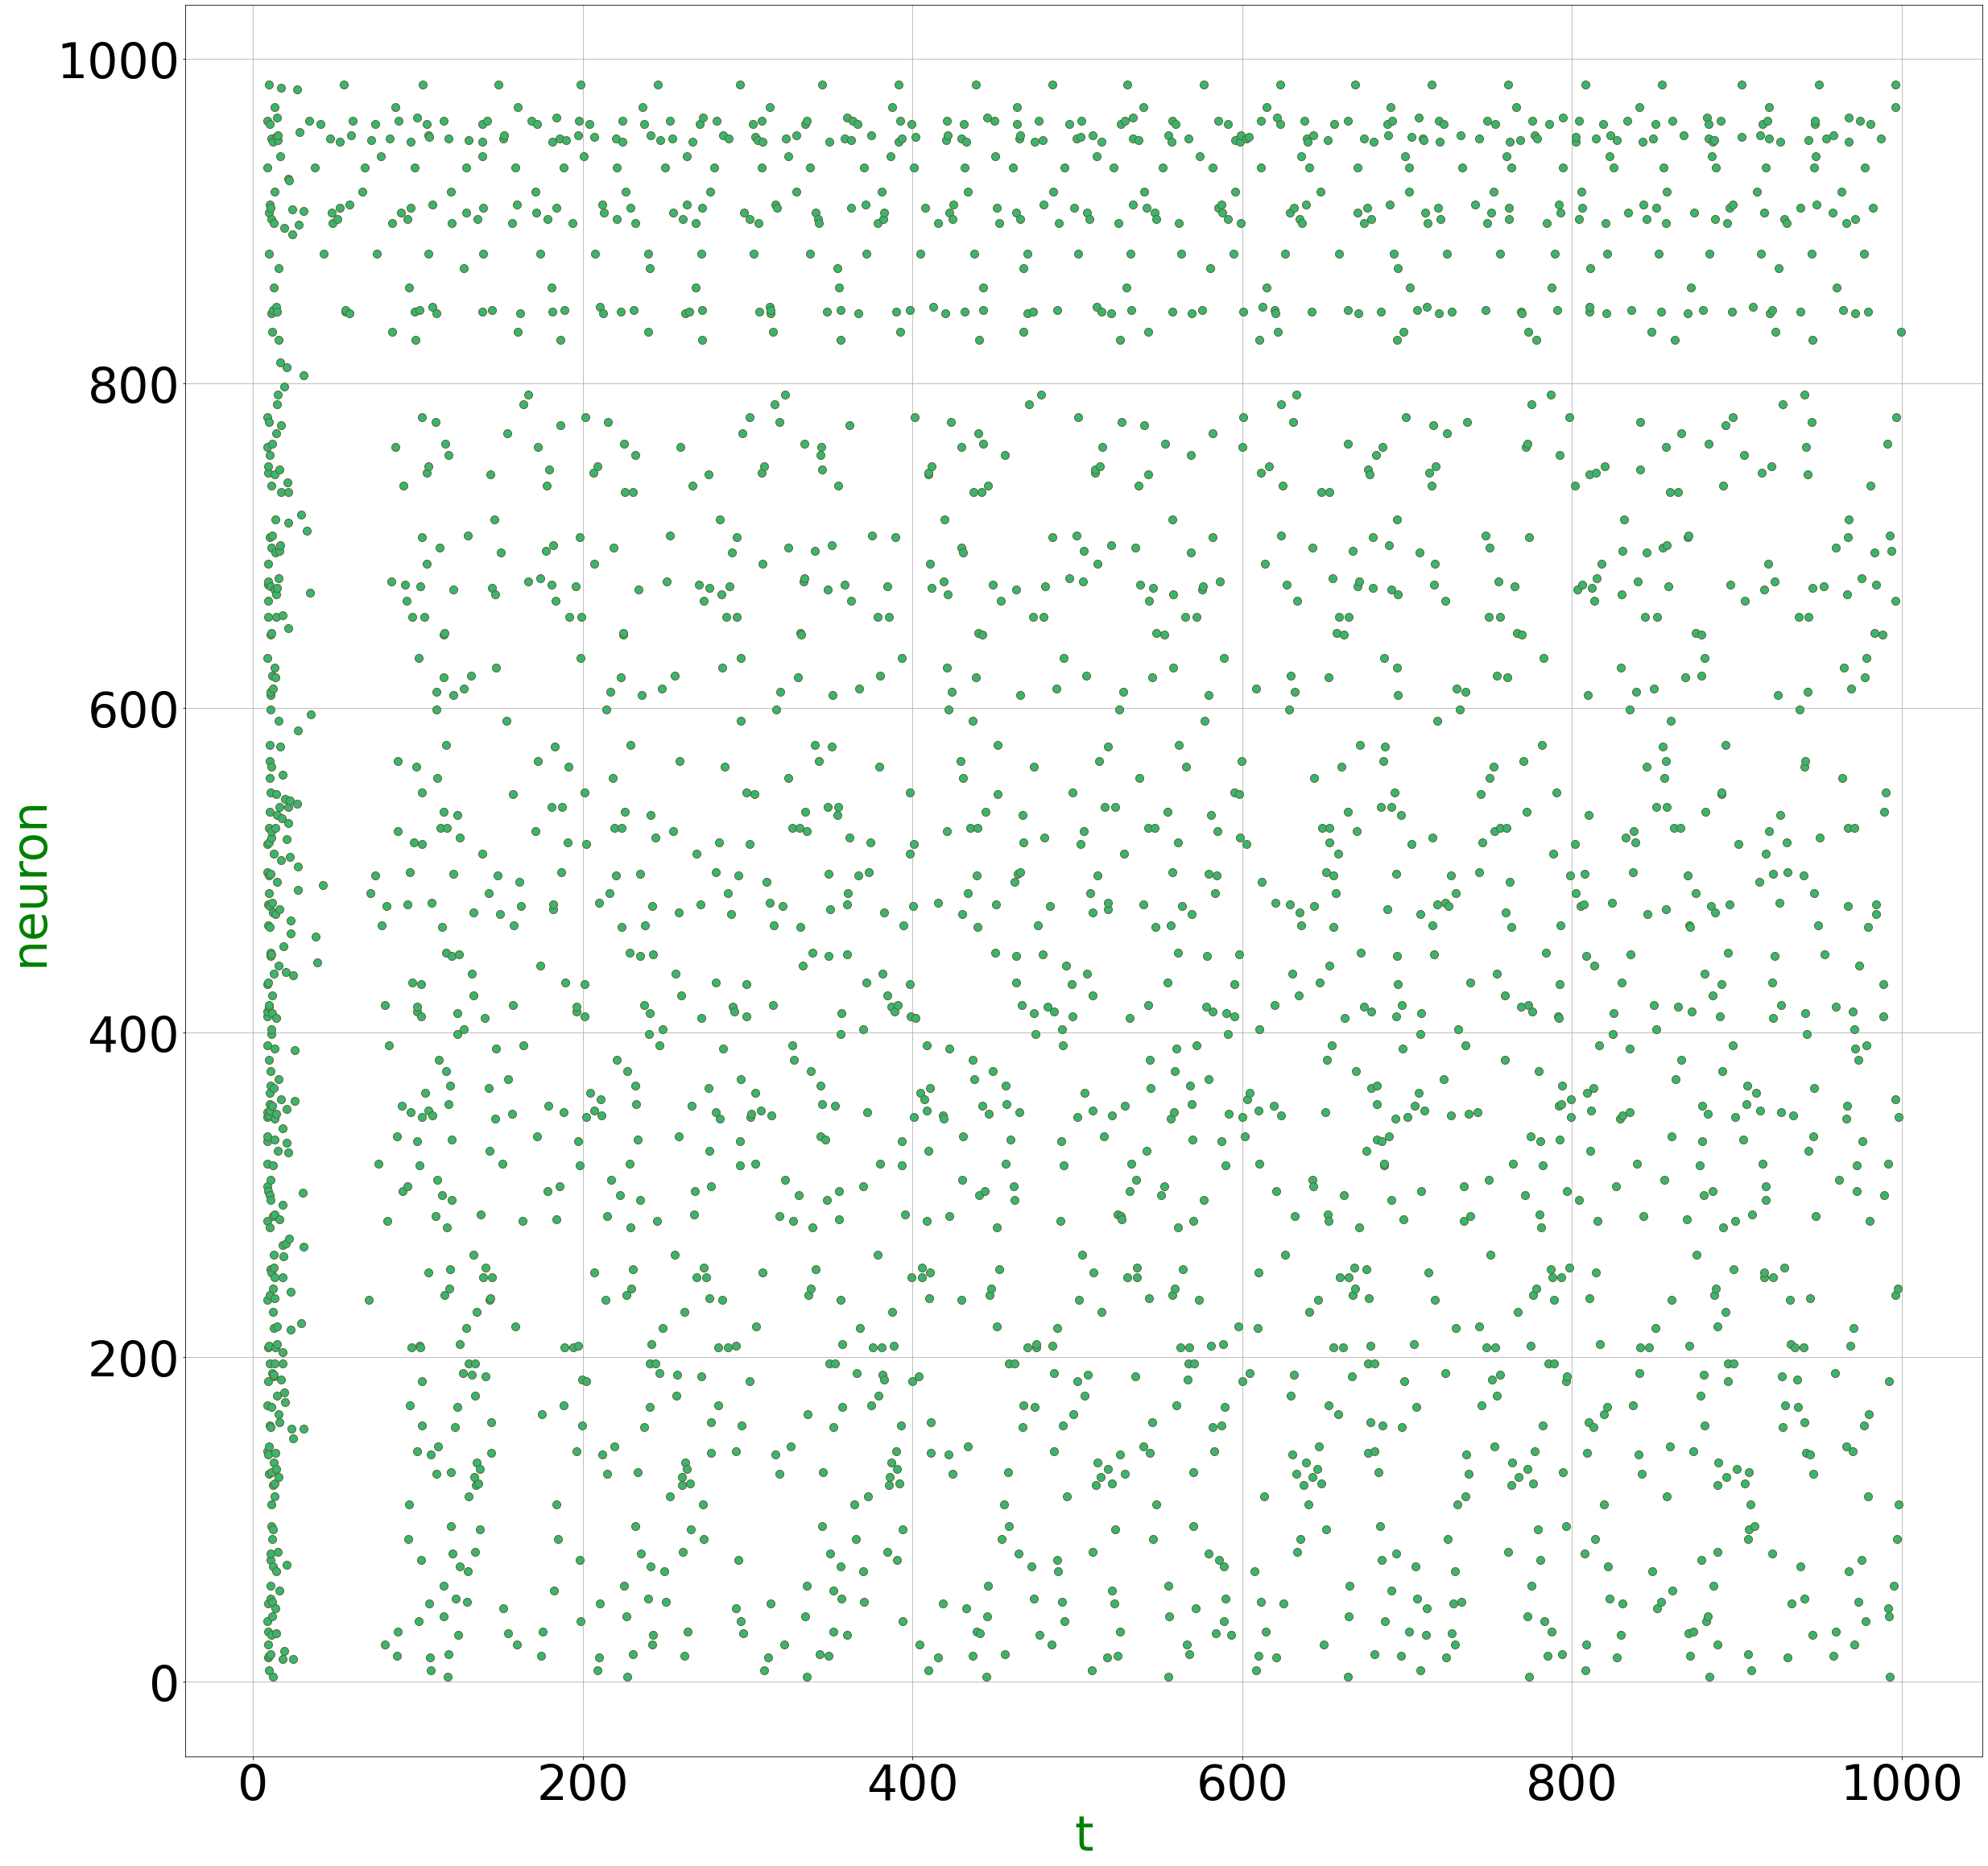

In [761]:
neur_graph(neur(1000, 800, 'uniform', False), 'u2')